Work in progress for roto based skull strip workflow
When finished, integrate this into your functions doc

In [55]:
import os
import nibabel as nib
import numpy as np
from numpy import asarray
from functions import *
from classes import *

In [56]:
from PIL import Image

In [57]:
proj_root = parent_directory()
print(proj_root)
input_filepath = os.path.join(proj_root, "media/sub-01/anat/sub-01_T2w.nii.gz")
output_folder = os.path.join(proj_root, "output/")
fmri = MRI_Anat(input_filepath)

/Users/joachimpfefferkorn/repos/neurovolume


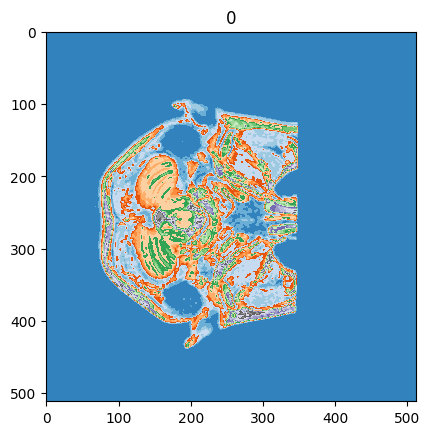

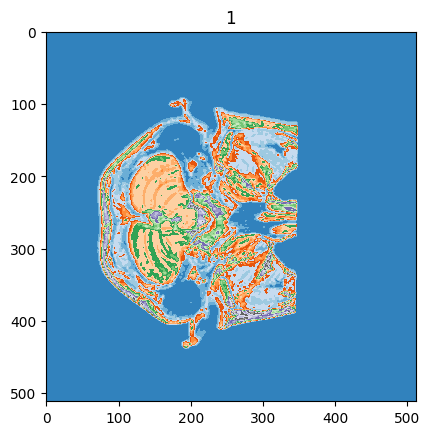

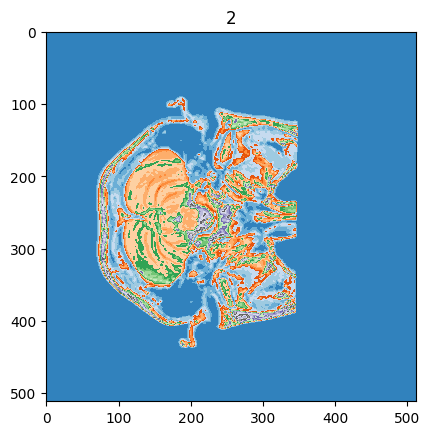

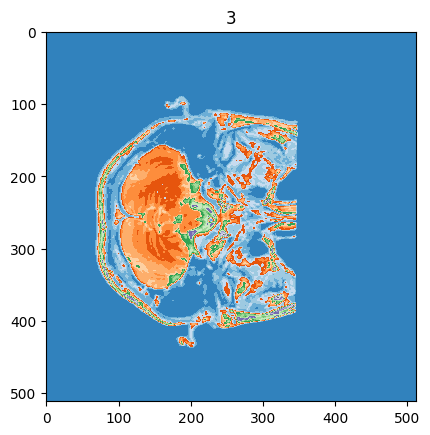

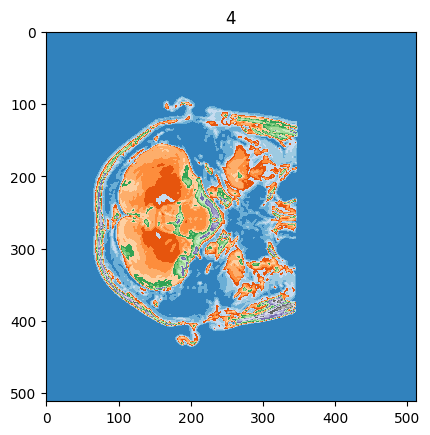

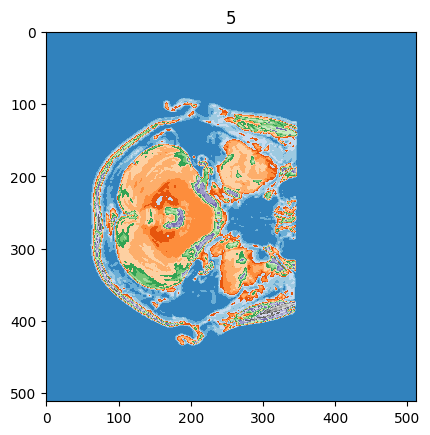

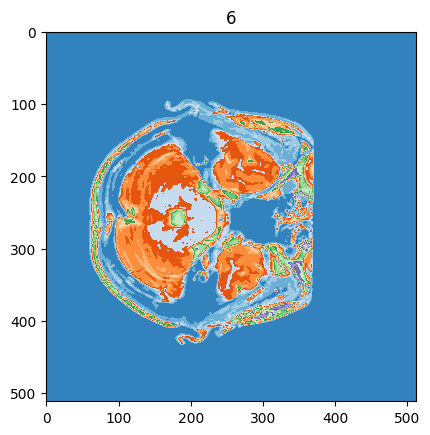

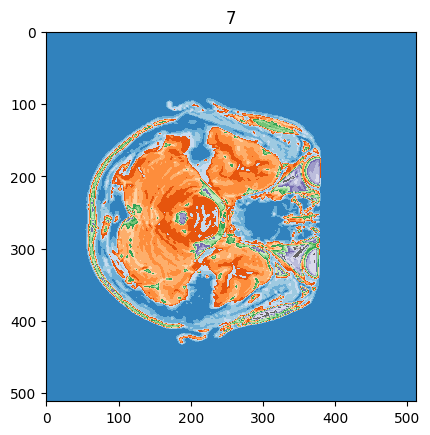

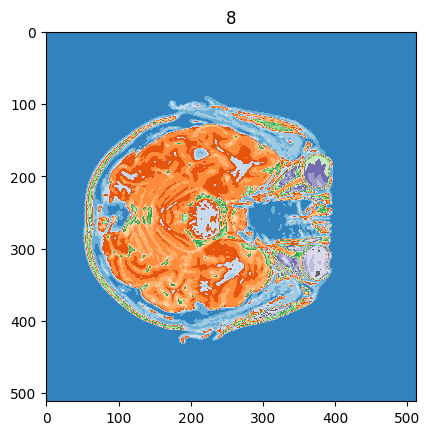

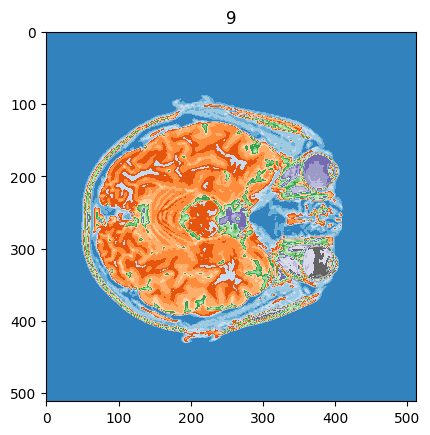

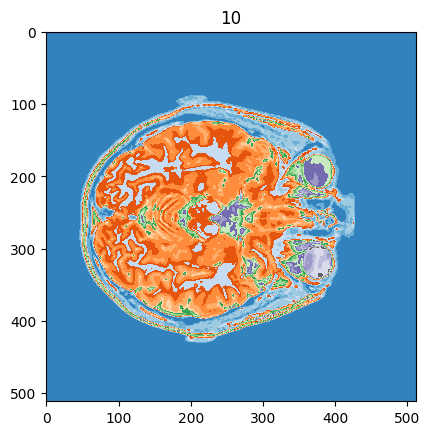

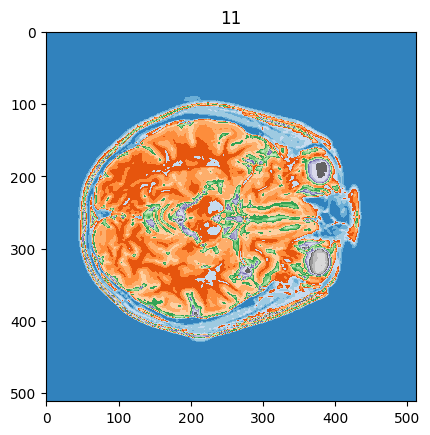

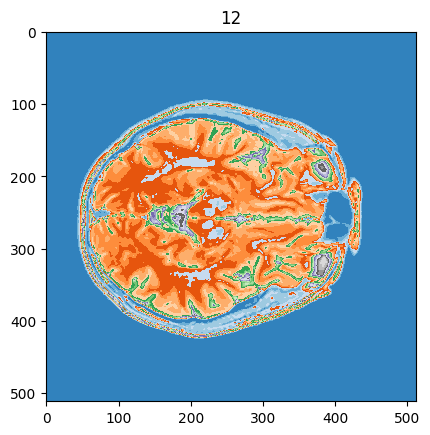

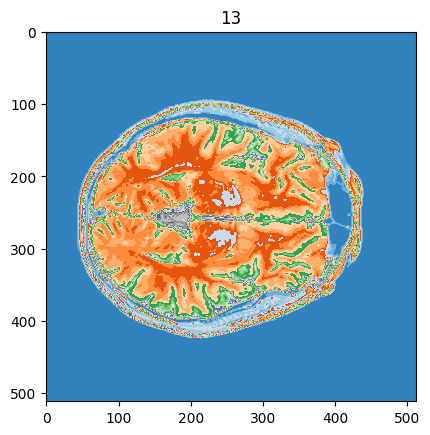

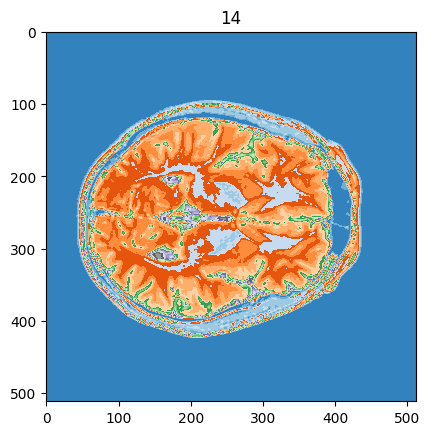

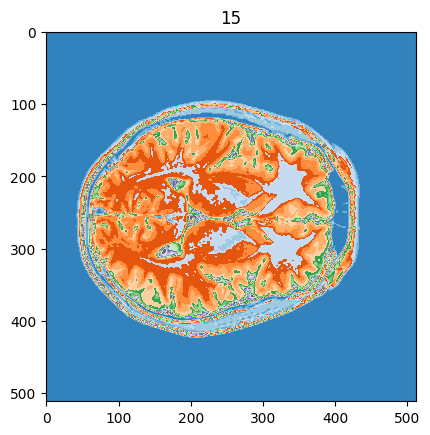

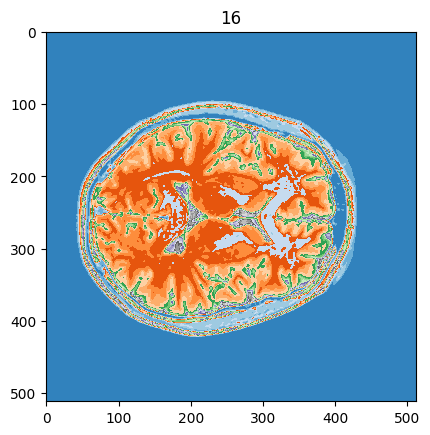

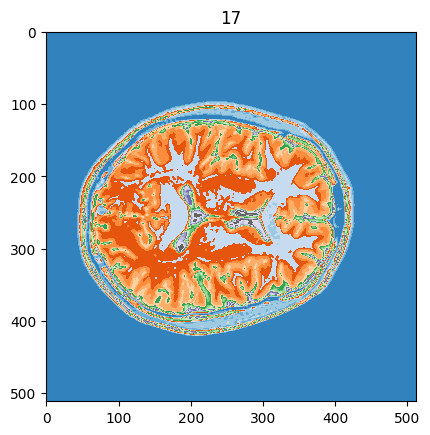

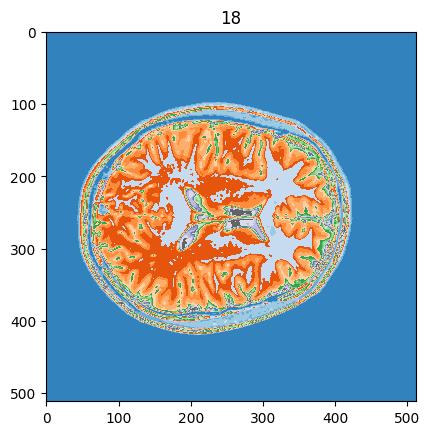

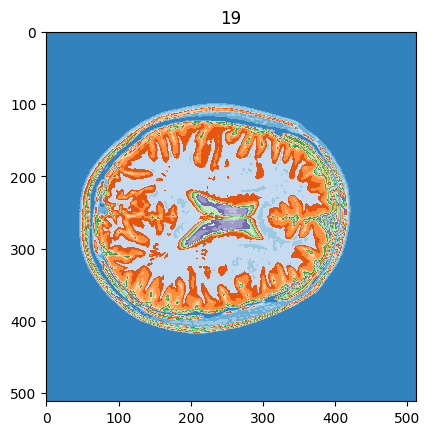

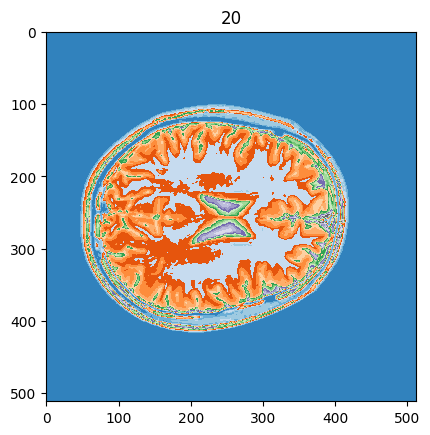

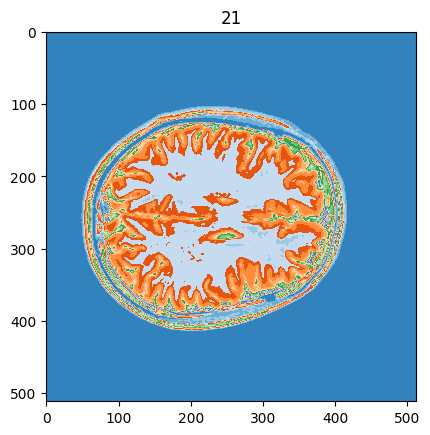

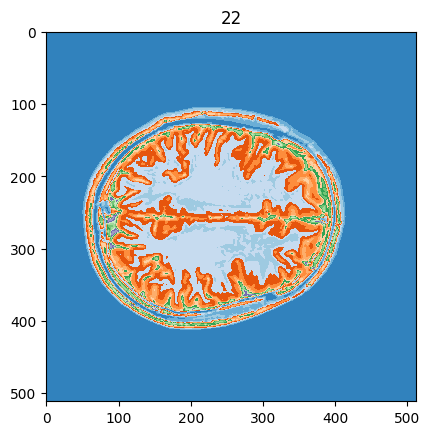

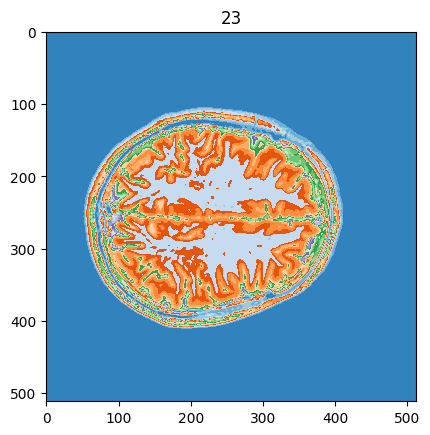

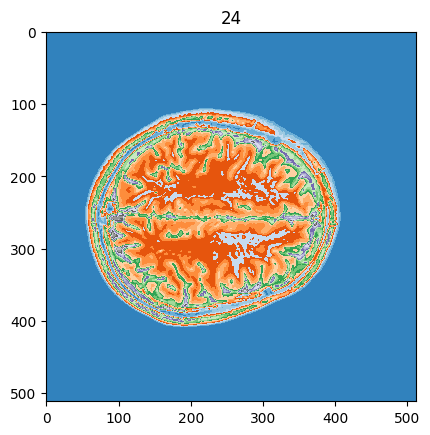

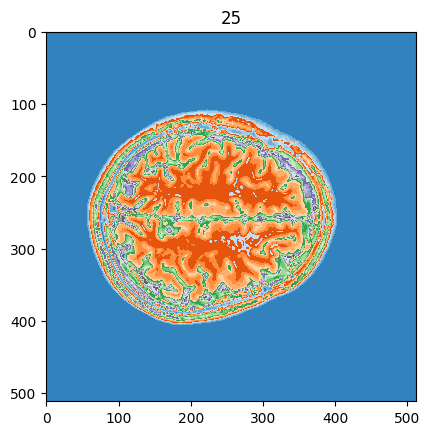

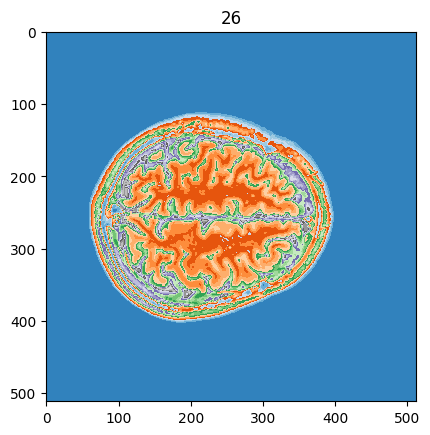

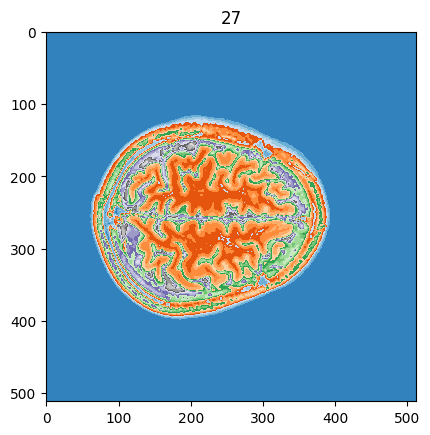

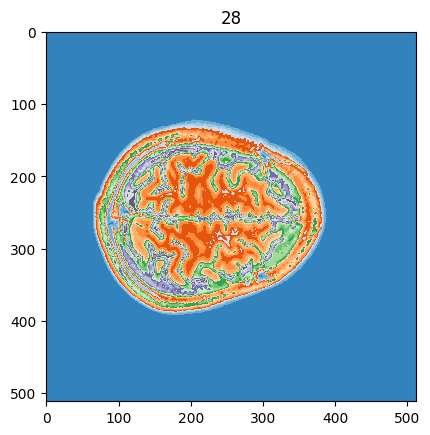

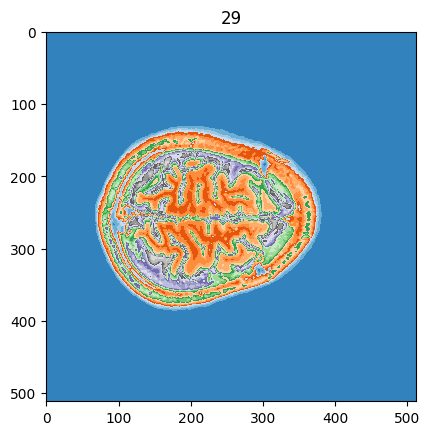

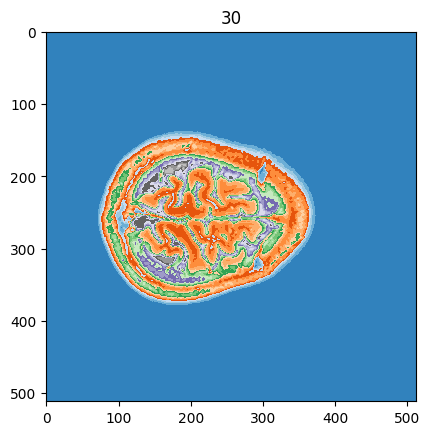

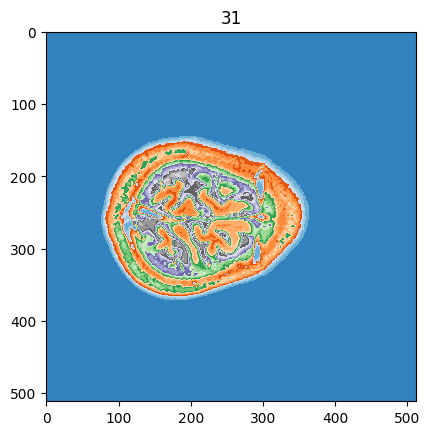

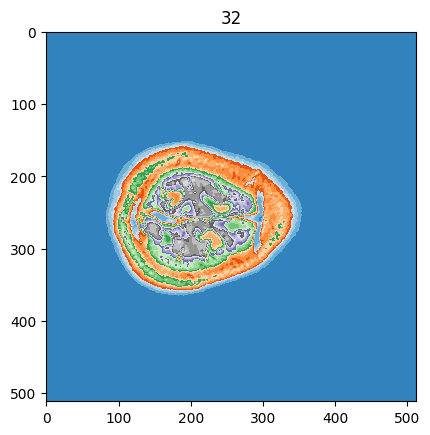

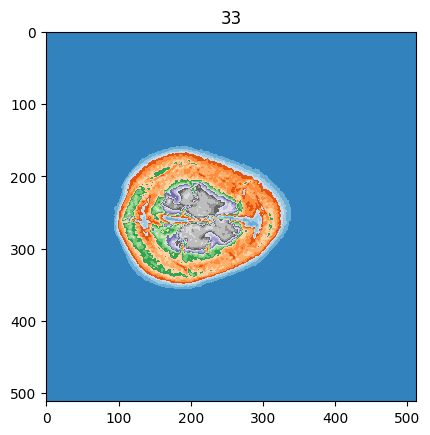

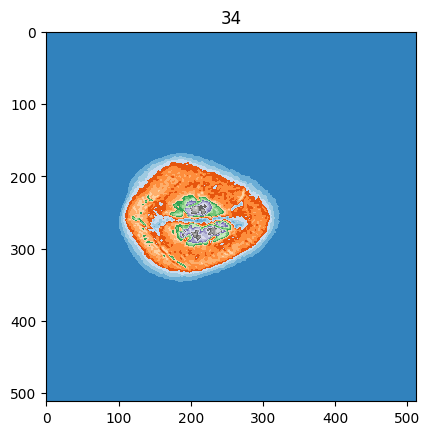

In [58]:
view_all_sagittal_slices(fmri.brain_data, "tab20c")

In [59]:
max_val = min_val = 0.0
for voxel in fmri.brain_data.flat:
    if voxel > max_val:
        max_val = voxel
    if voxel < min_val:
        min_val = voxel
print(min_val, max_val)

0.0 3777.9999686032534


In [60]:
# GPT normalize function
#Not sure why this works over quantize, but here we are
#We need to do this to get it 8 bit for the rotoscoping
def normalize_to_256(array):
    array_min = np.min(array)
    array_max = np.max(array)
    normalized_array = 255 * (array - array_min) / (array_max - array_min)
    return normalized_array.astype(np.uint8)

In [61]:
#normalized = normalize_array(fmri.brain_data)
raw = Image.fromarray(normalize_to_256(fmri.brain_data[:,:,10]))
im = raw.convert('L')
im.save("test_slice.jpeg")

In [62]:
def save_slices(brain_data, output_folder="/Users/joachimpfefferkorn/repos/neurovolume/output/slice_images"):
    for slice in range(brain_data.shape[2]):
        raw = Image.fromarray(normalize_to_256(brain_data[:,:,slice]))
        im = raw.convert('L')
        im.save(f"{output_folder}/{slice}.jpeg")

In [63]:
save_slices(fmri.brain_data)

We have saved this out, rotoscoped, and rendered out a luma matte

In [64]:
#Lets create the mask volume
def build_mask(mask_sequence_path):
    masks = {} #dictionary with number being the key, the mask array as the value
    for entry in os.listdir(mask_sequence_path):
        if entry.endswith(".jpg"):
            img_path = f"{mask_sequence_path}/{entry}"
            with Image.open(img_path) as img:
                masks[entry[-6:-4]] = (asarray(img.convert('L')) > 0)
                #Creates a boolean mask for now #TODO come to think of it, you could do string or enum labels for anatomy here!
                #TODO some scalar number to give soft transitions between the grids
    return masks
masks = build_mask("/Users/joachimpfefferkorn/repos/neurovolume/output/slice_images_mask")

In [65]:
print(masks.keys())
print(masks)

dict_keys(['33', '27', '26', '32', '18', '24', '30', '31', '25', '19', '21', '09', '08', '34', '20', '22', '23', '12', '06', '07', '13', '05', '11', '10', '04', '00', '14', '28', '29', '15', '01', '17', '03', '02', '16'])
{'33': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), '27': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), '26': array([[False, False, False, ..., False, False, False],
   

Let's quickly do a visual check to see if these masks line up with their slices

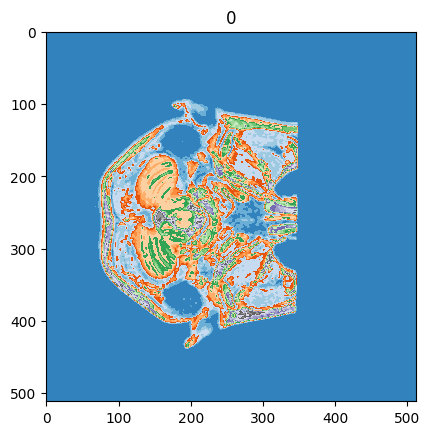

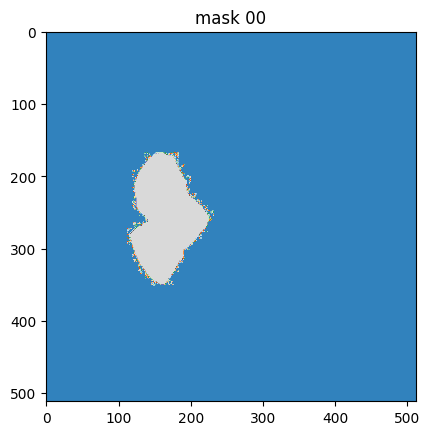

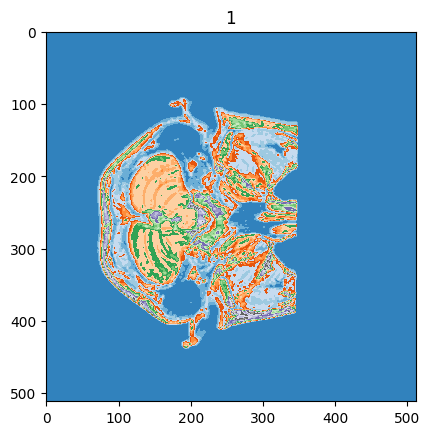

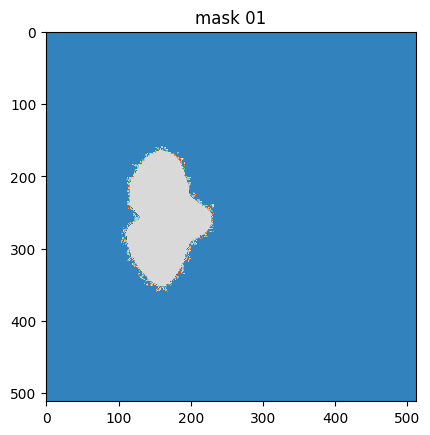

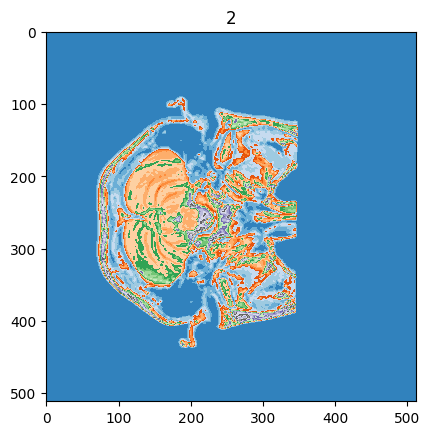

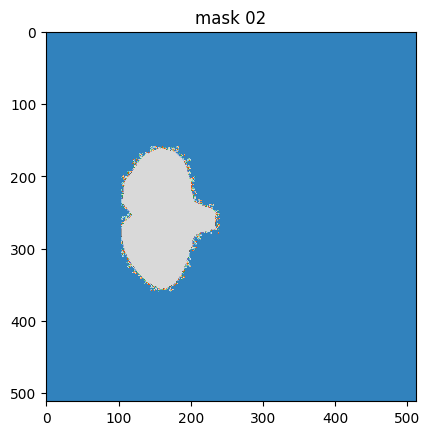

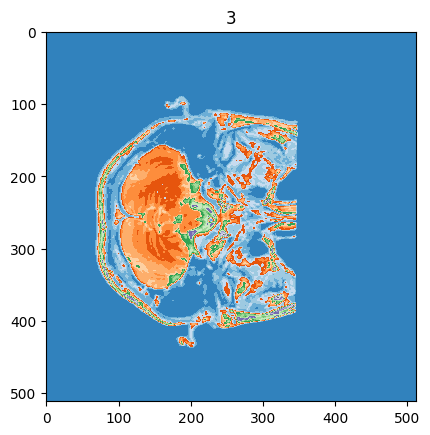

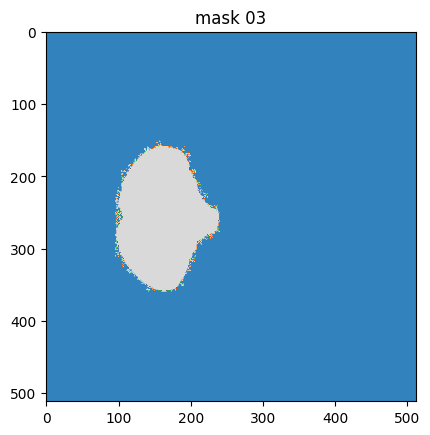

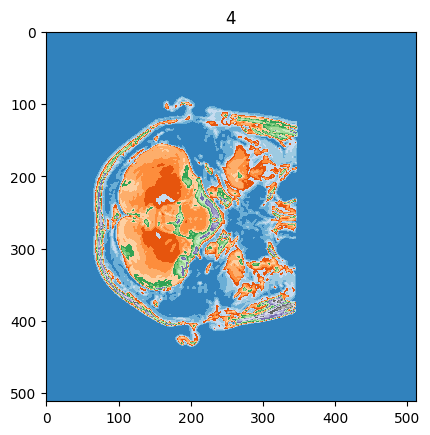

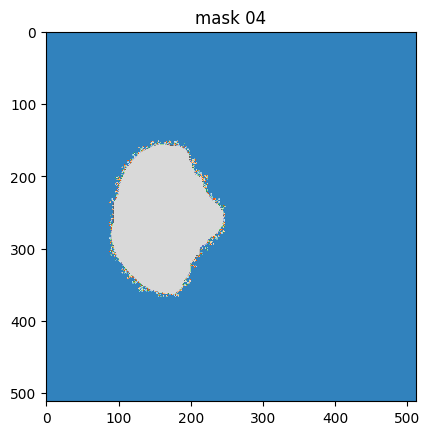

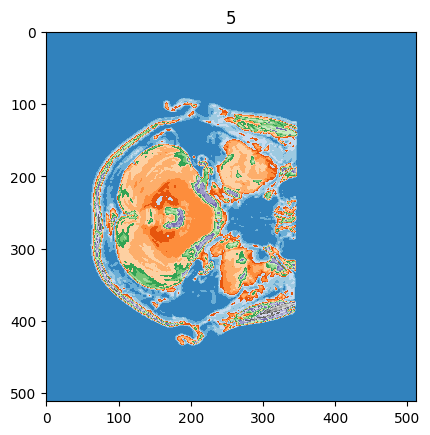

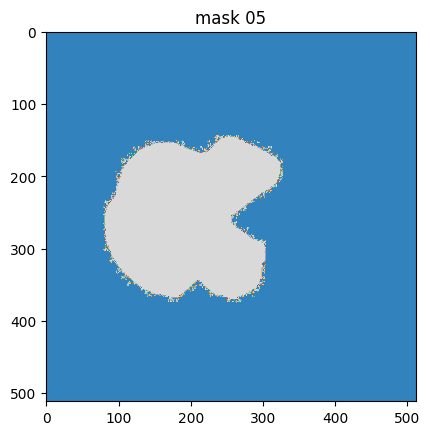

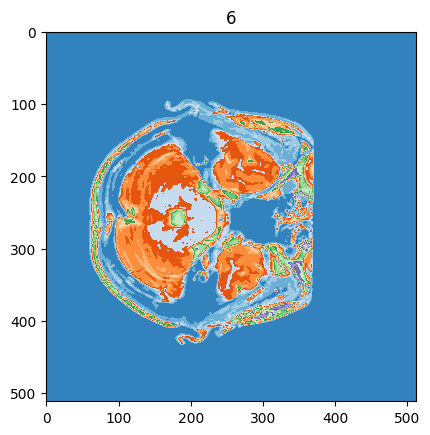

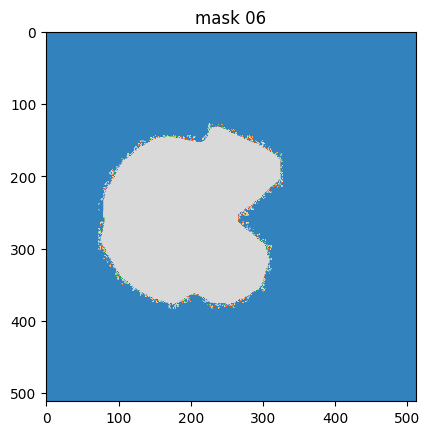

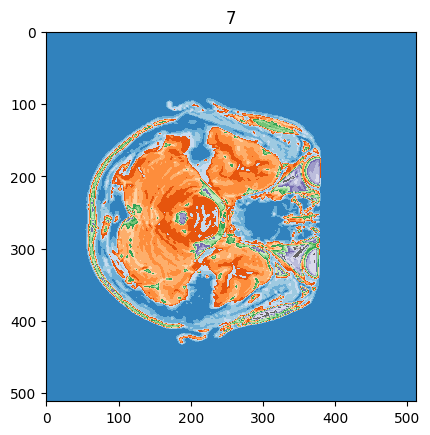

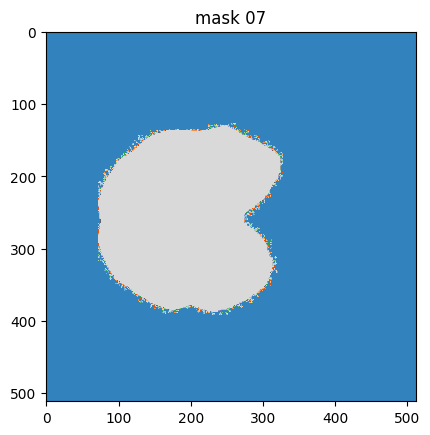

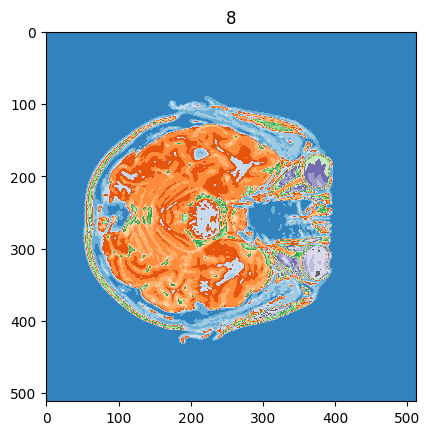

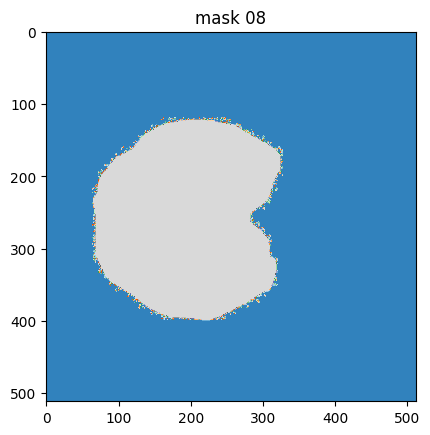

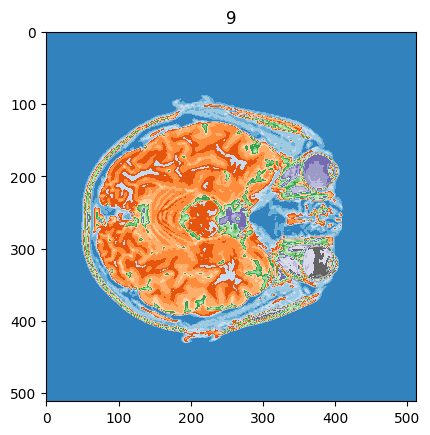

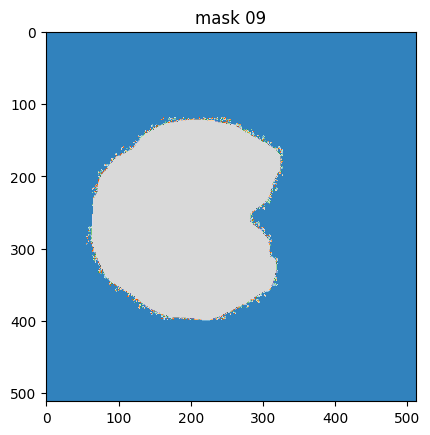

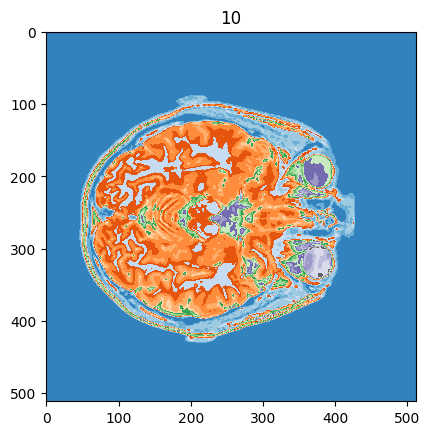

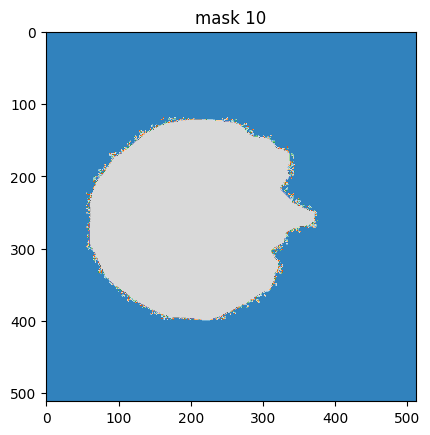

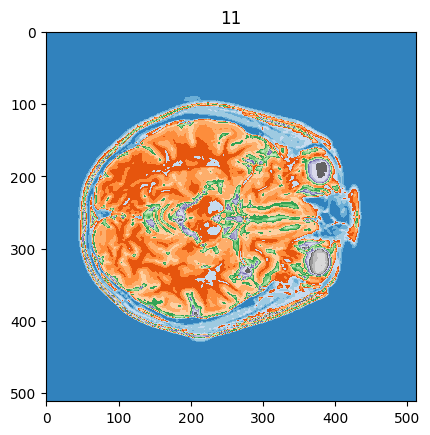

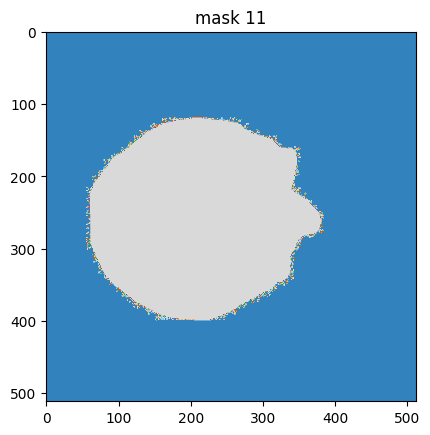

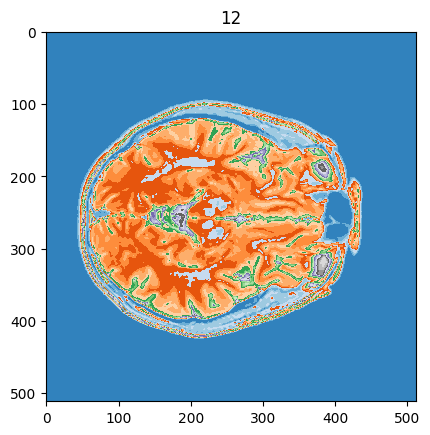

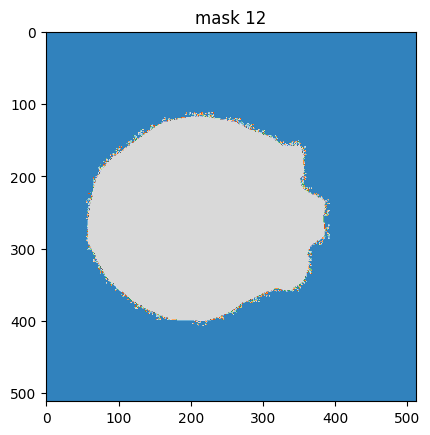

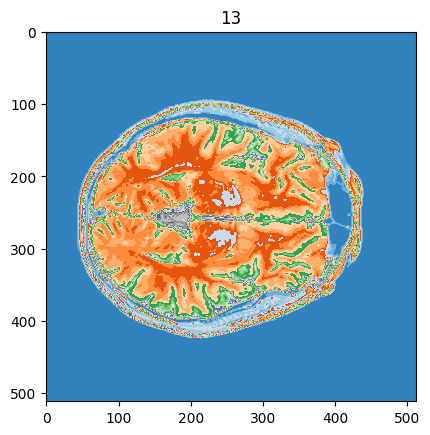

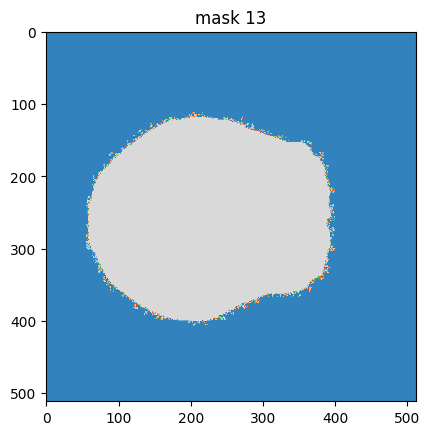

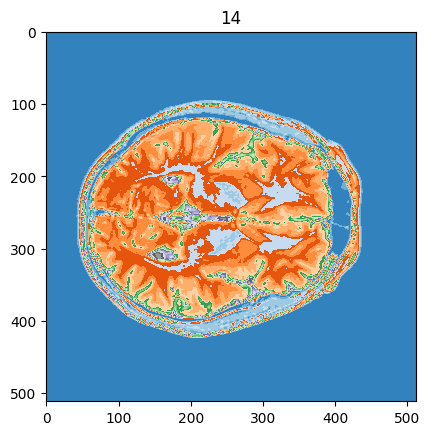

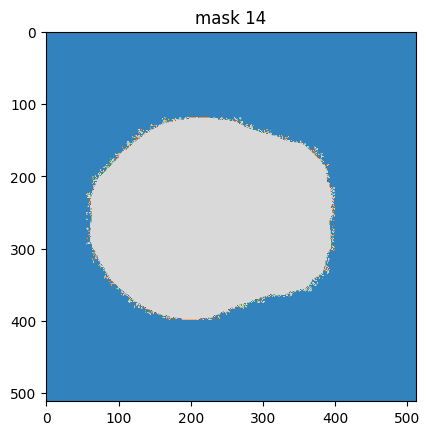

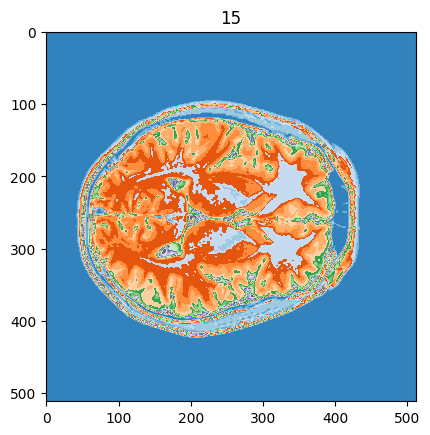

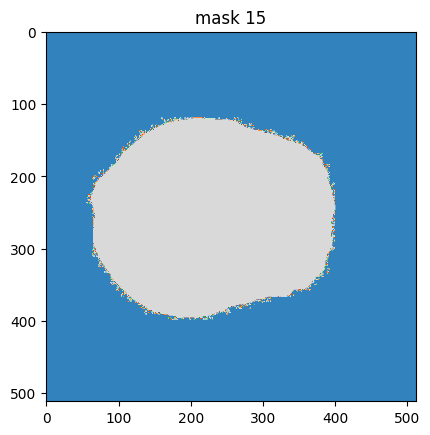

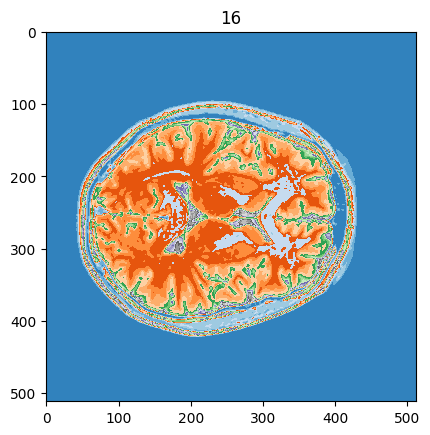

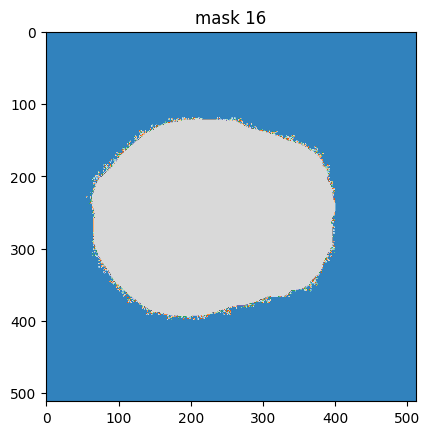

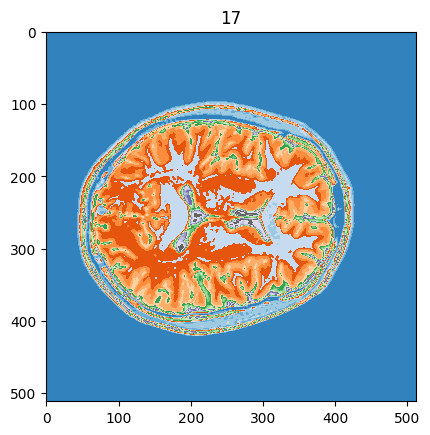

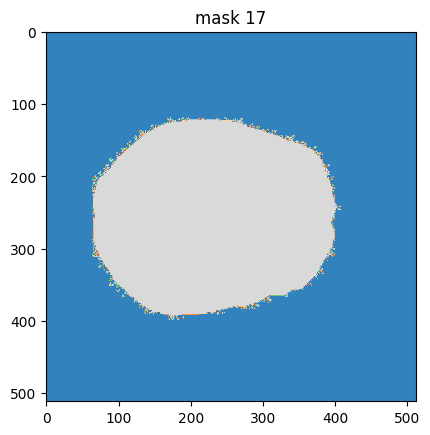

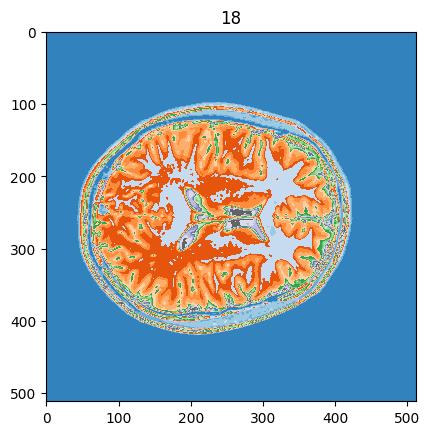

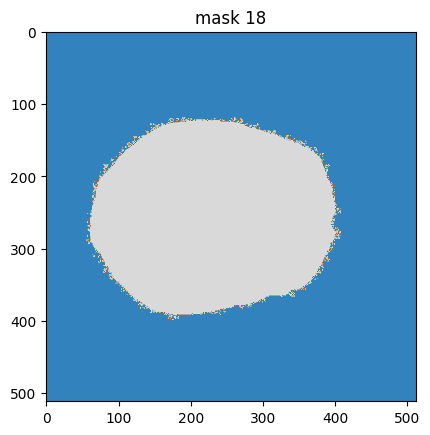

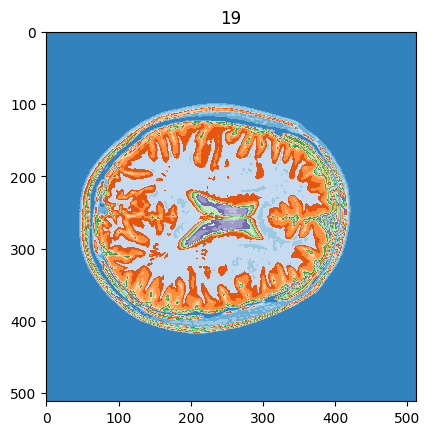

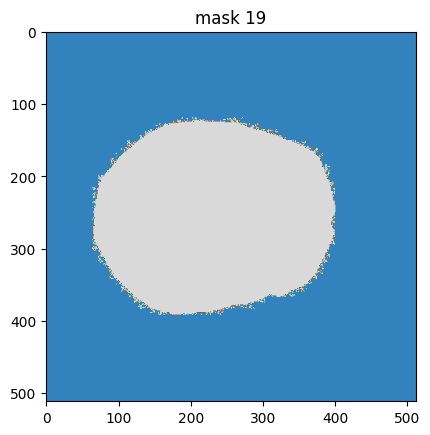

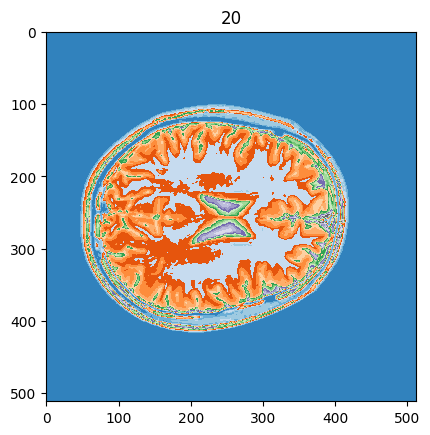

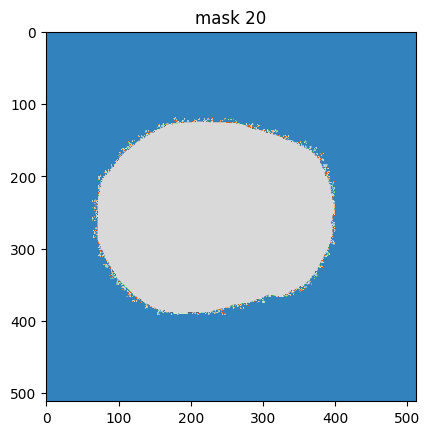

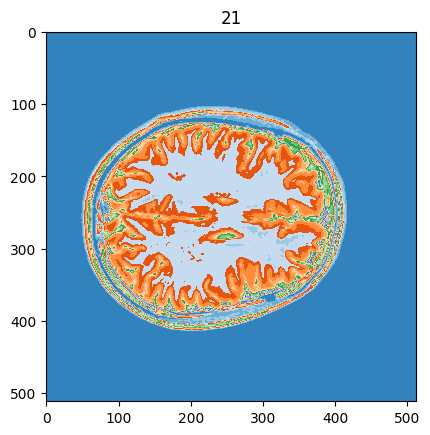

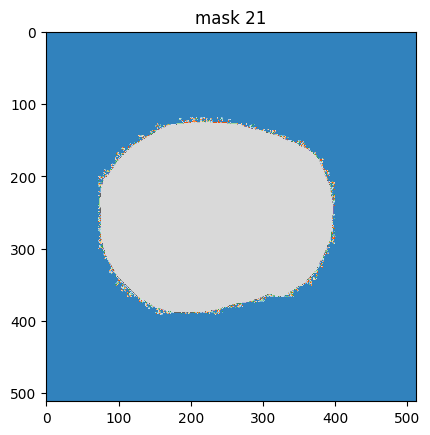

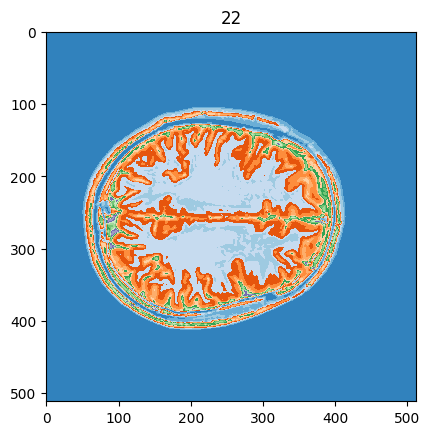

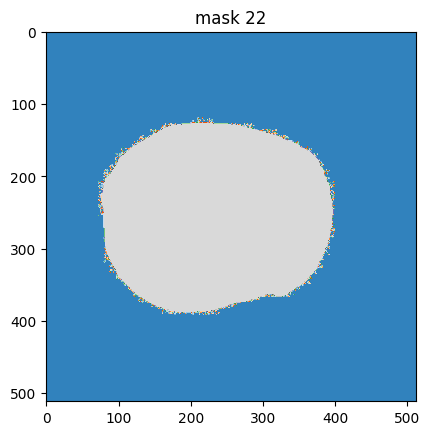

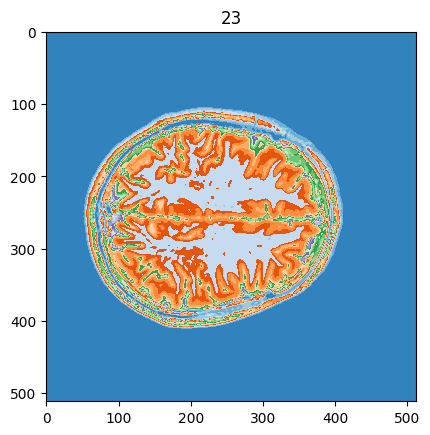

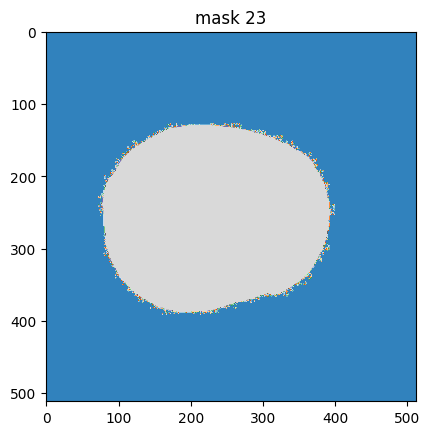

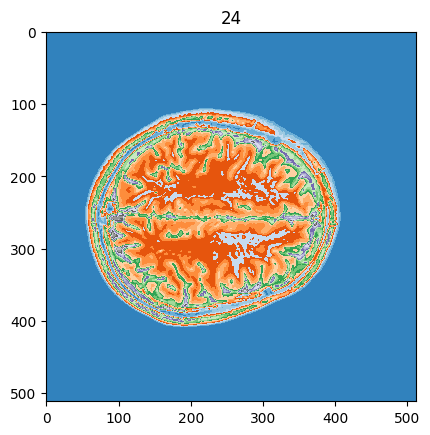

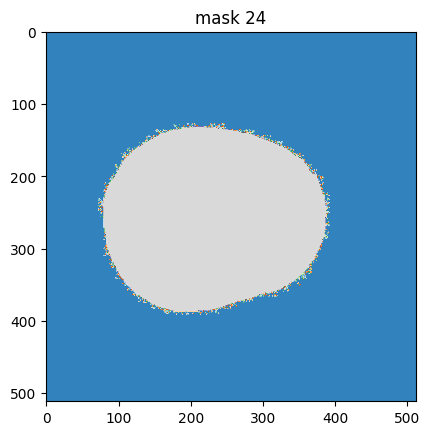

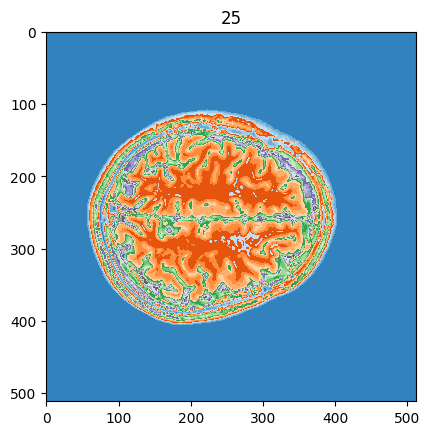

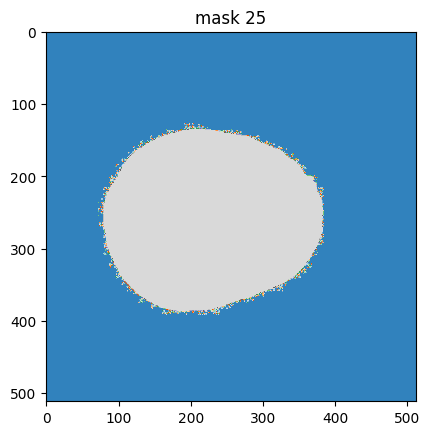

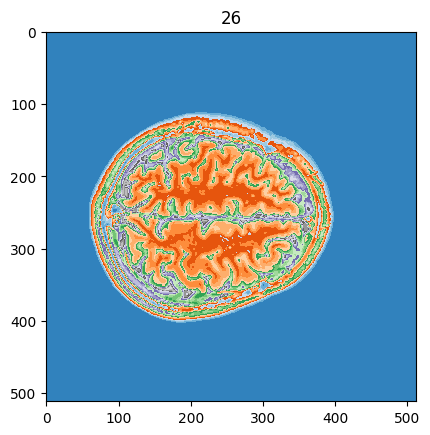

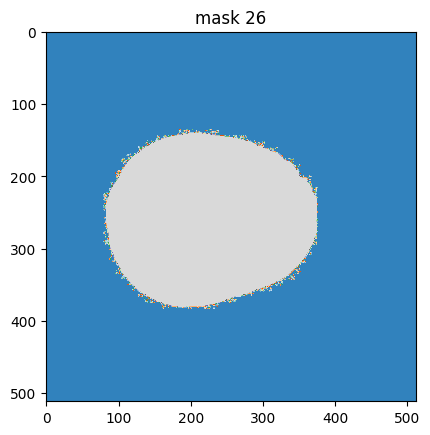

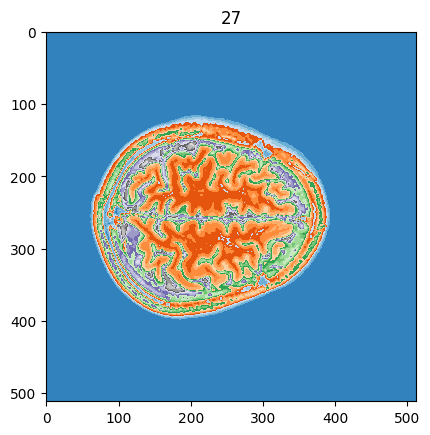

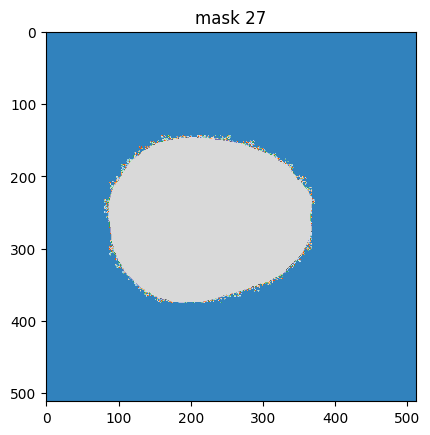

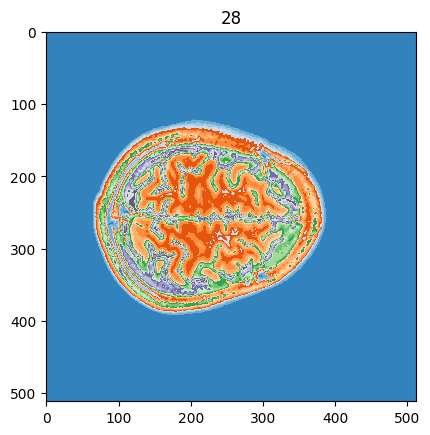

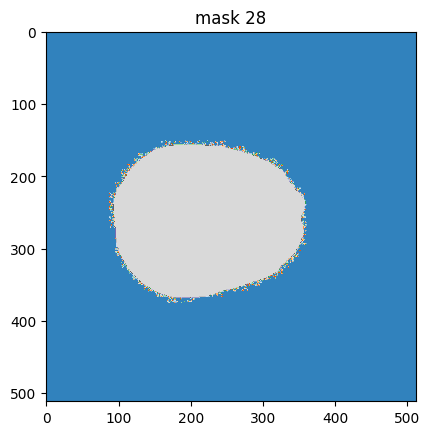

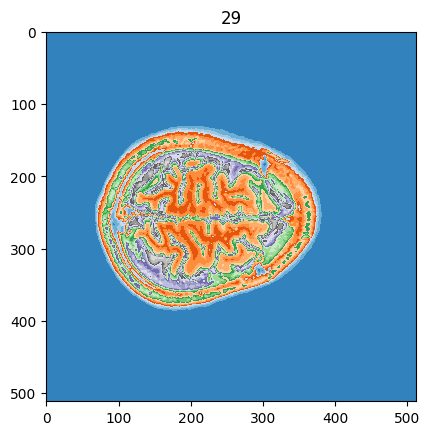

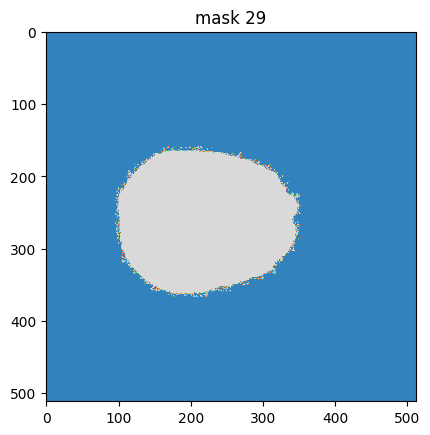

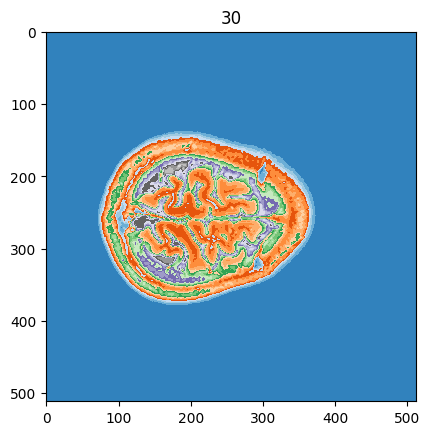

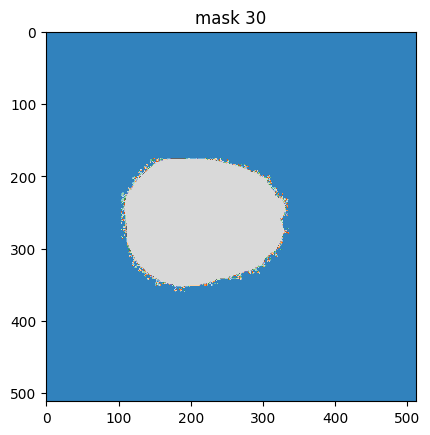

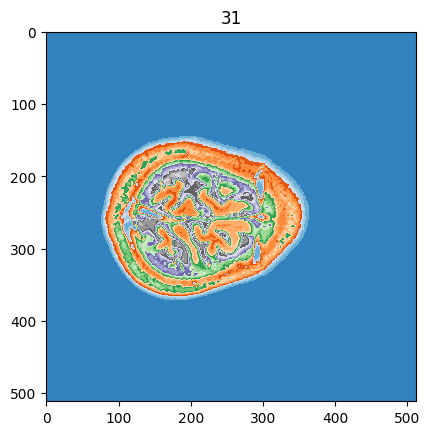

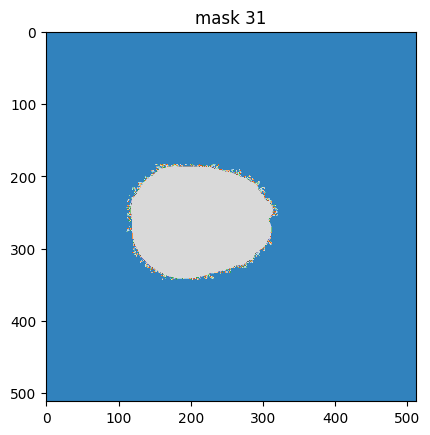

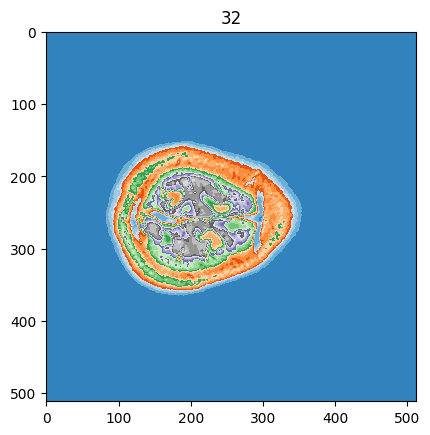

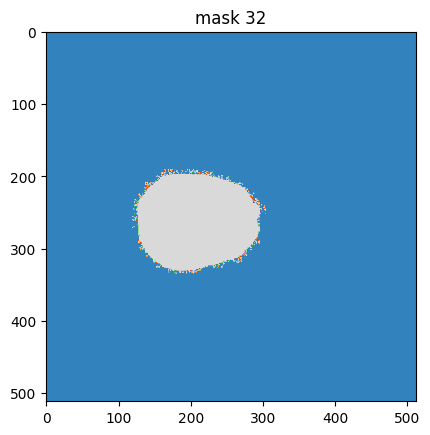

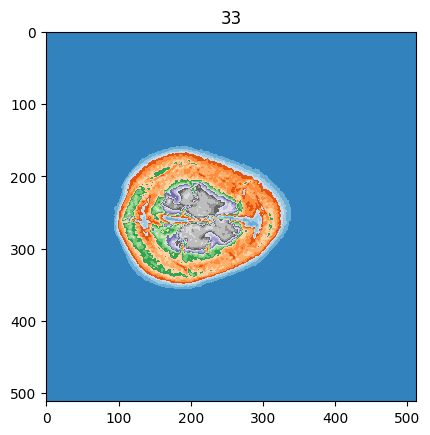

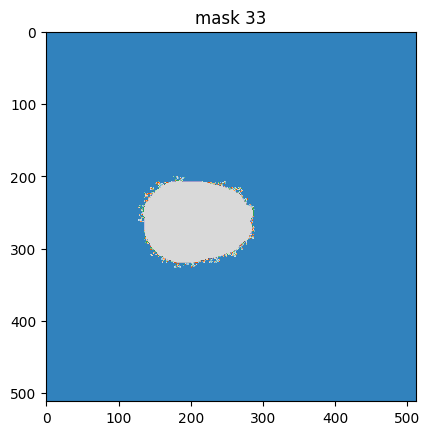

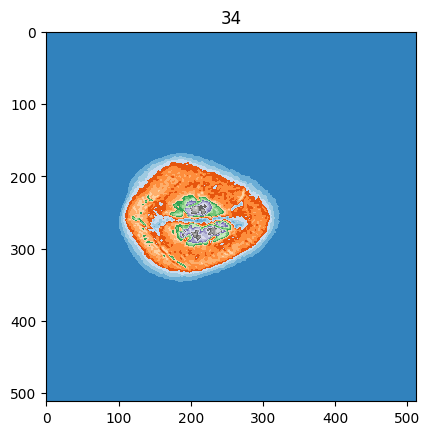

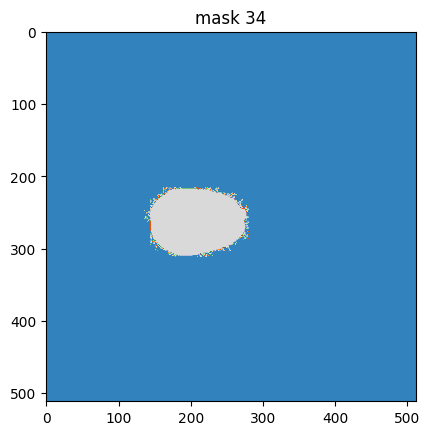

In [66]:
for i in range(fmri.brain_data.shape[2]):
#    print(fmri.brain_data.shape[:,:,i])
    slice = fmri.brain_data[:,:,i]
    view_slice(slice, title=str(i))
    index = f"0{i}"[-2:]     #lil hacky ngl
    view_slice(masks[index], title=f"mask {index}")

Looks good! Let's apply these masks to the `numpy` arrays 
In order to do so: we'll create two new arrays, the anatomy (outside of the mask) and brain (inside the mask). When creating the `VDB` grid, these will be two different `grids` with two different names

First, let's create a volume which is just the masks:

In [67]:
mask_3D = np.empty(fmri.brain_data.shape)
for index in sorted(masks):
    # print("masks", masks[mask].shape)
    # print("empty 3d array to fill ", mask_3D[:,:,int(mask)].shape)
    mask_3D[:,:,int(index)] = masks[index]

**Now we create two arrays:**

`brain` is the brain anatomy, and uses the mri data only where the `mask_3D` array at that index is `True`

`exterior_anat` is everything else, it uses the mri data only where the `mask_3D` array at that index is `False`

**We also need to normalize and run that obnoxious `create_volume` thing**

In [68]:
brain = create_volume((np.where(mask_3D==True,np.array(normalize_array(fmri.brain_data)), 0.0)))
exterior_anat = create_volume((np.where(mask_3D==False,np.array(normalize_array(fmri.brain_data)), 0.0)))
#TODO DRY this

Quick dummy check of these

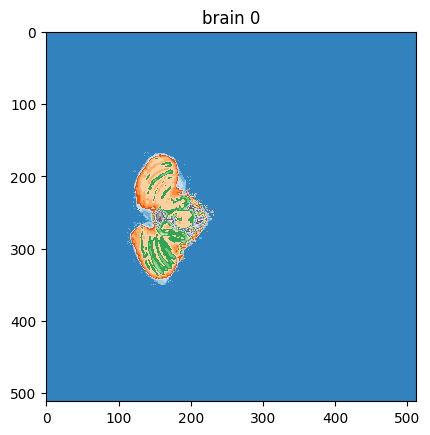

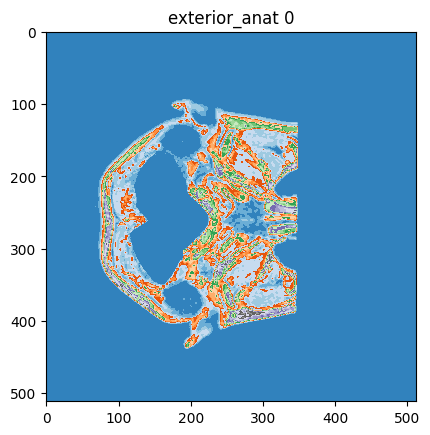

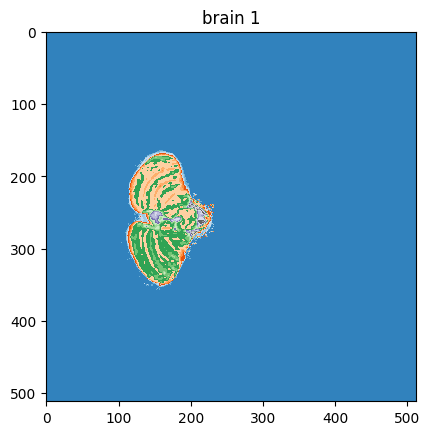

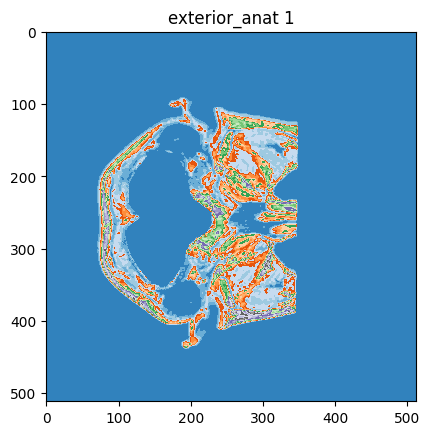

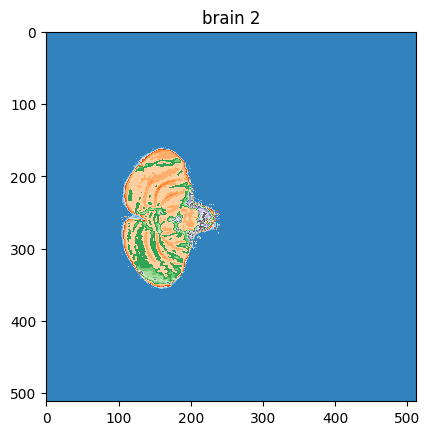

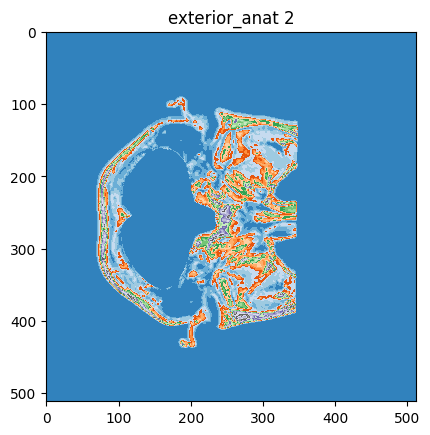

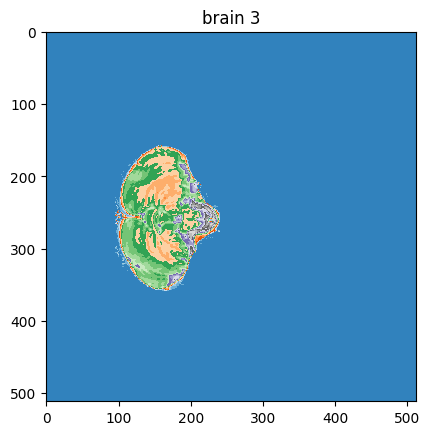

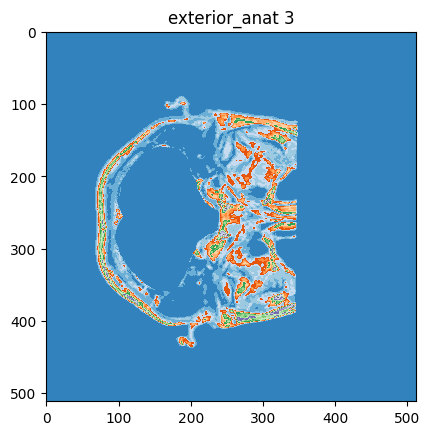

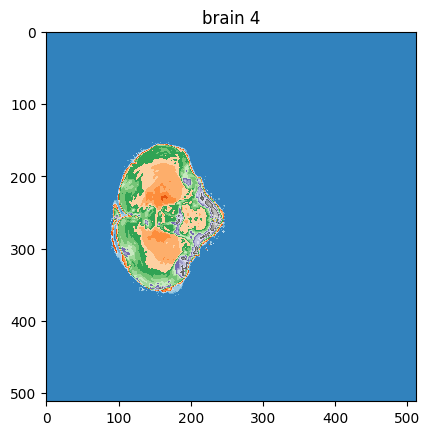

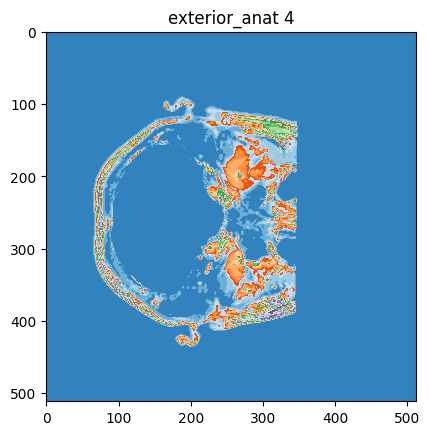

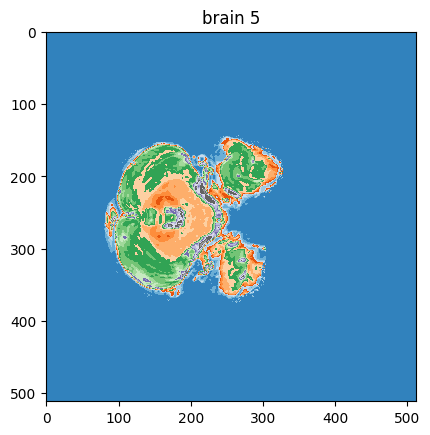

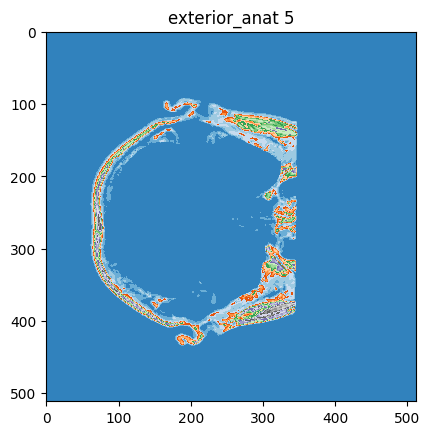

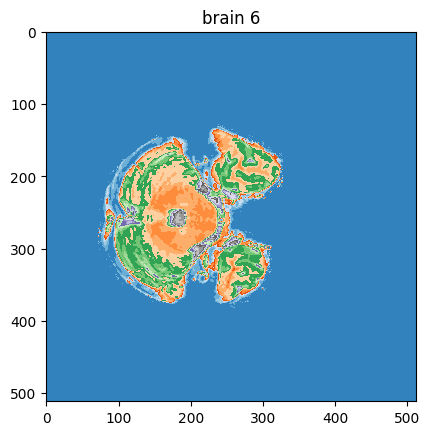

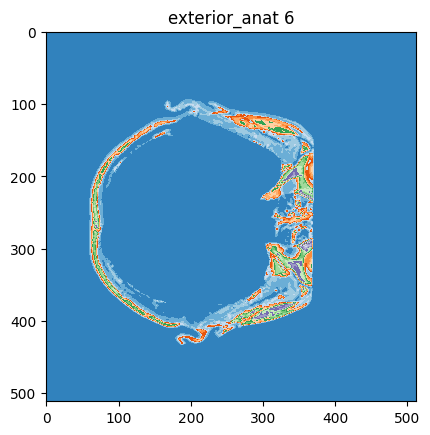

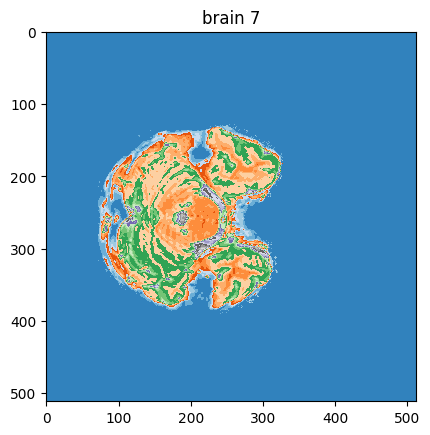

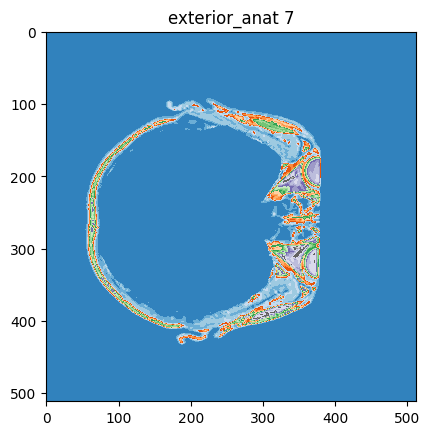

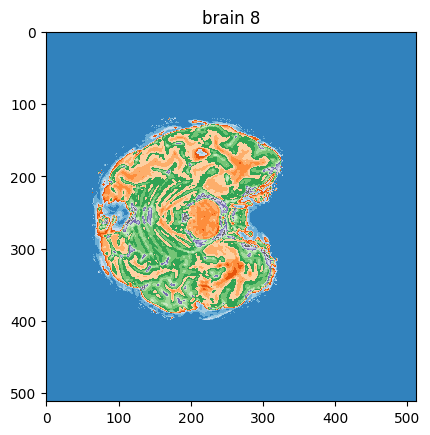

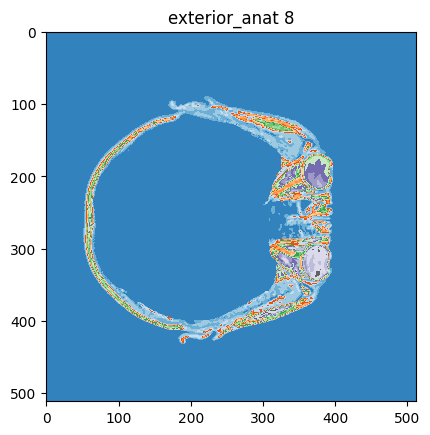

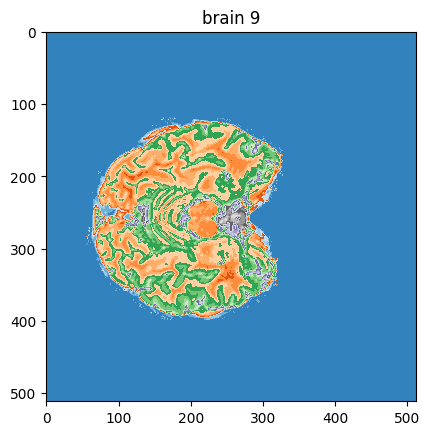

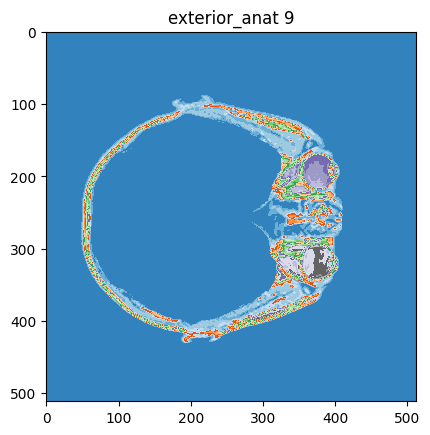

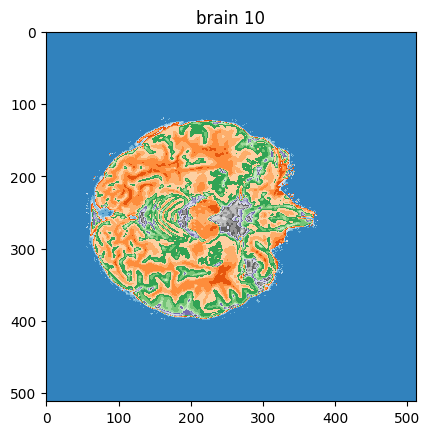

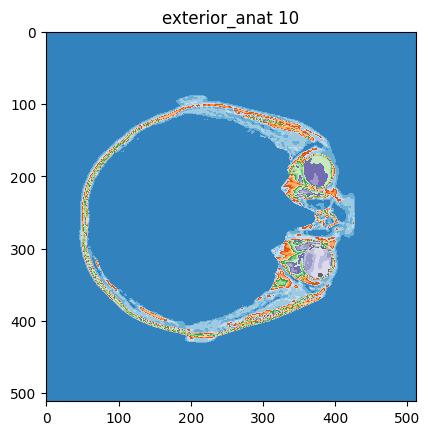

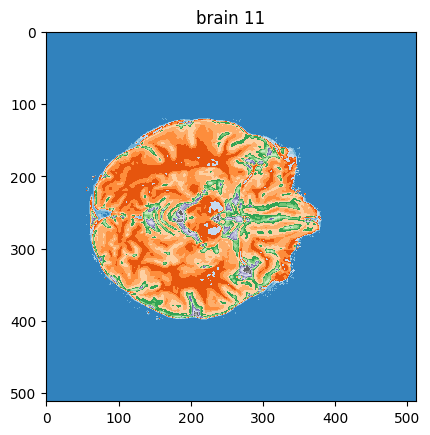

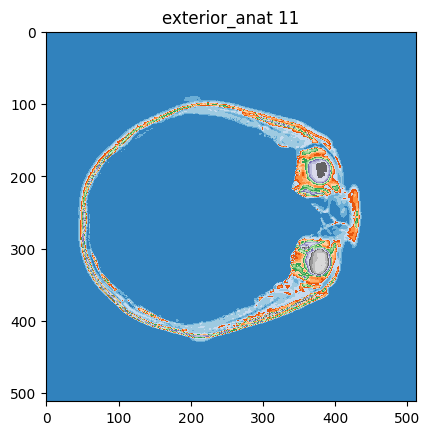

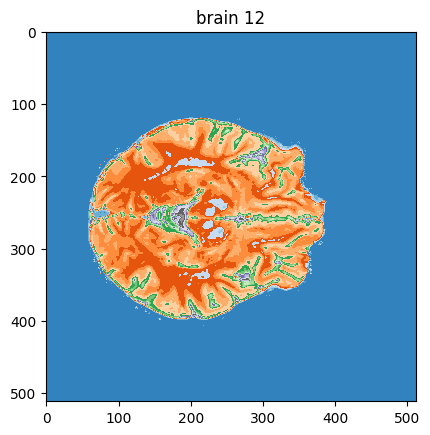

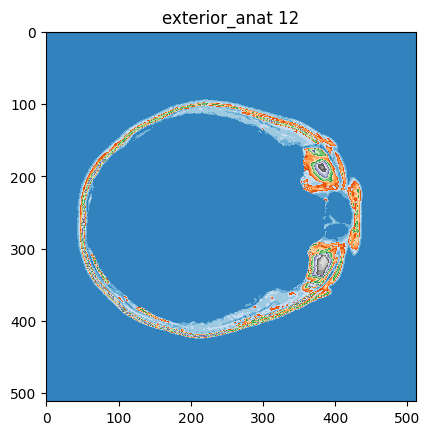

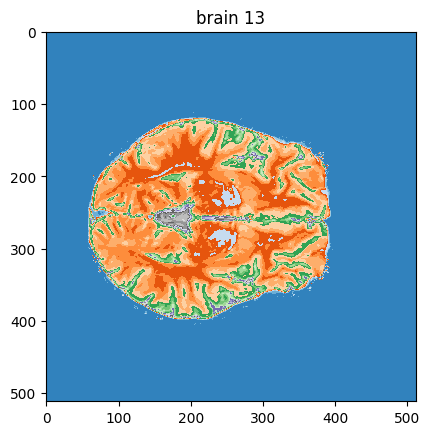

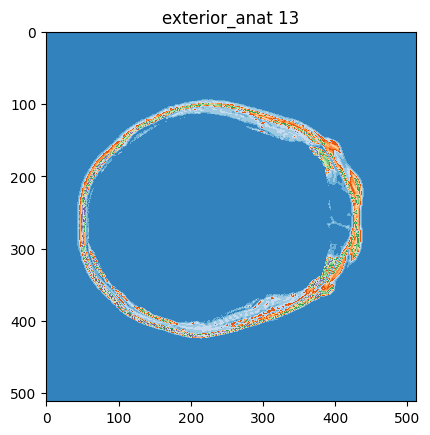

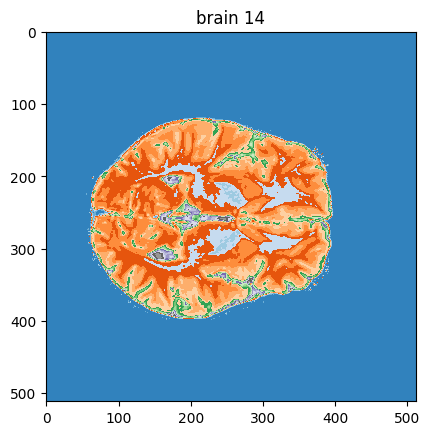

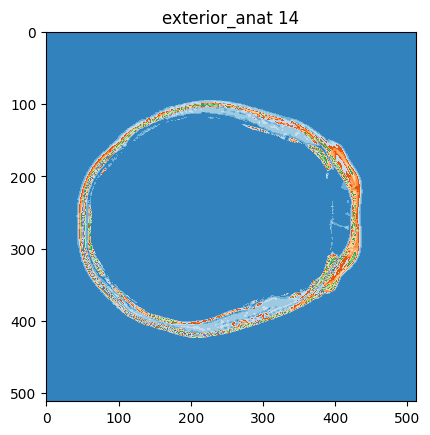

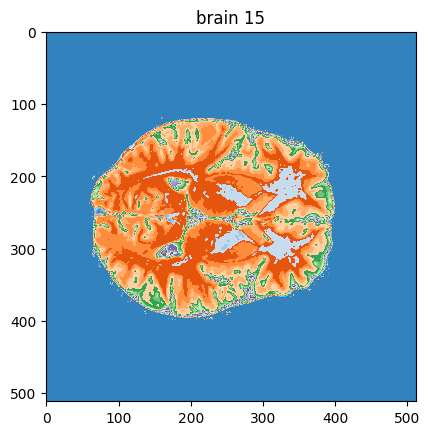

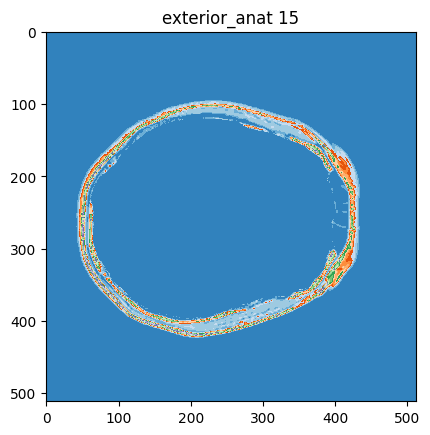

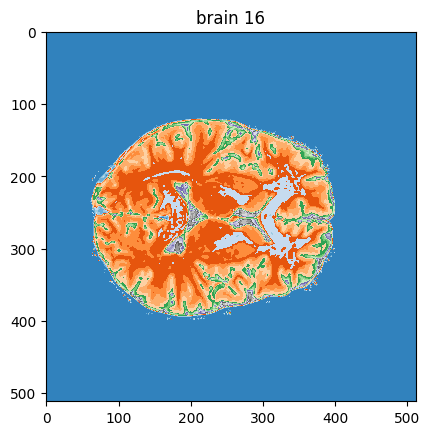

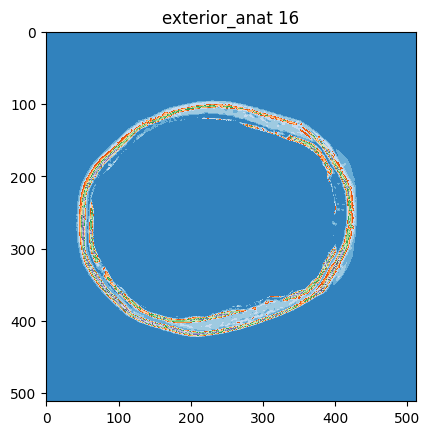

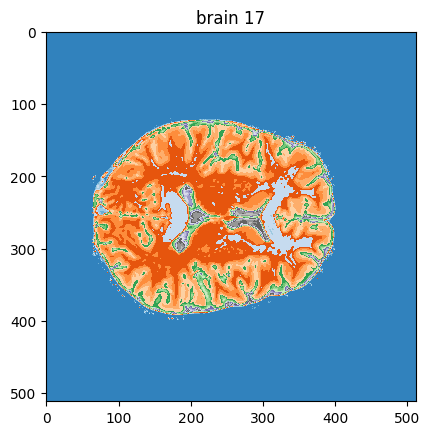

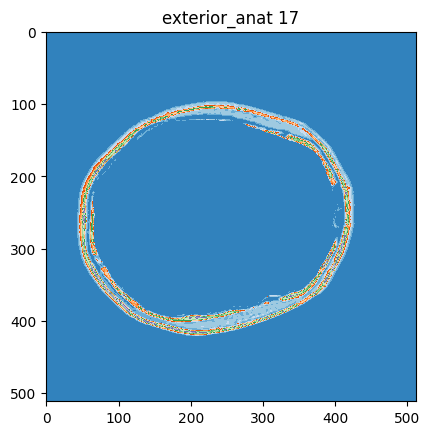

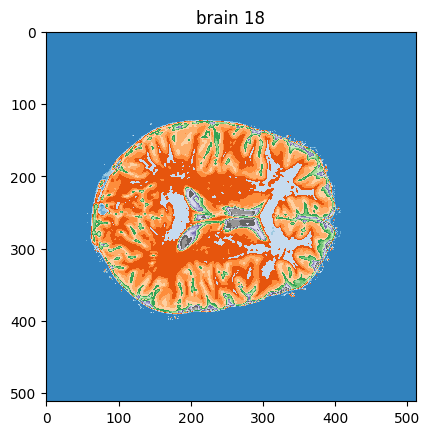

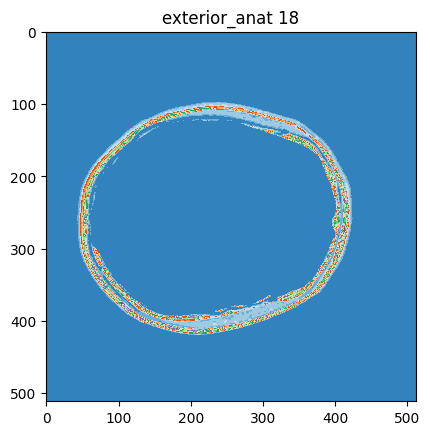

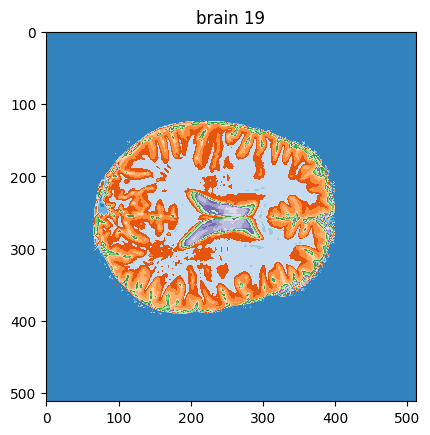

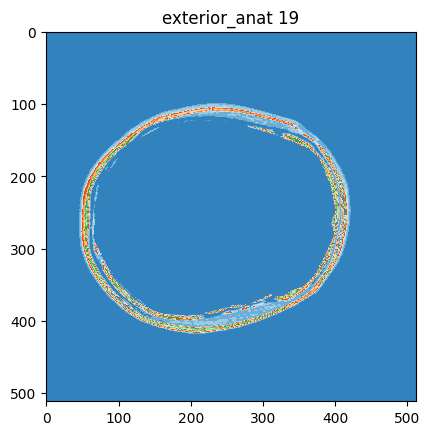

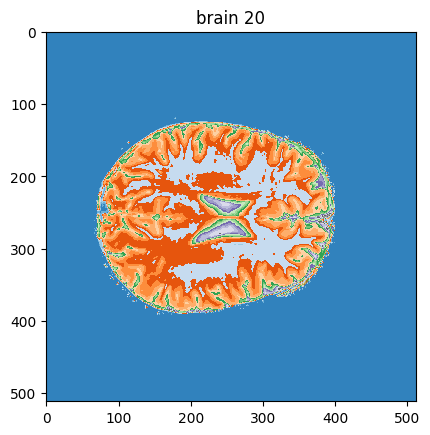

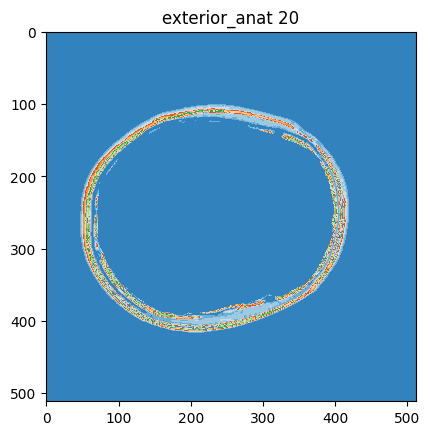

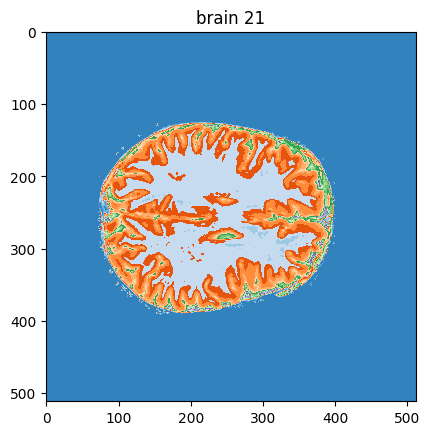

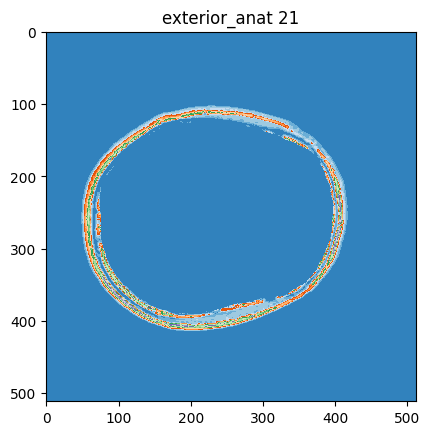

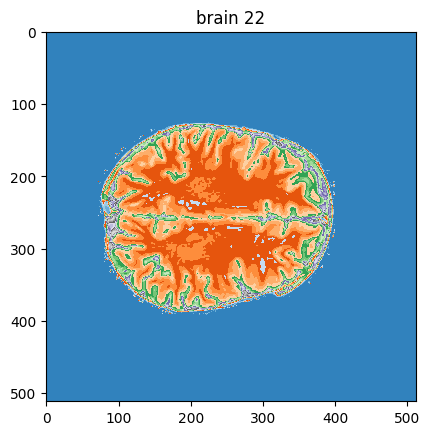

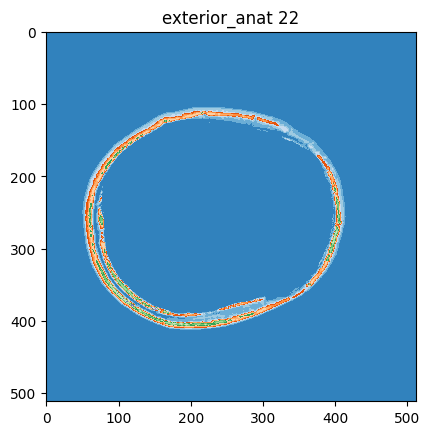

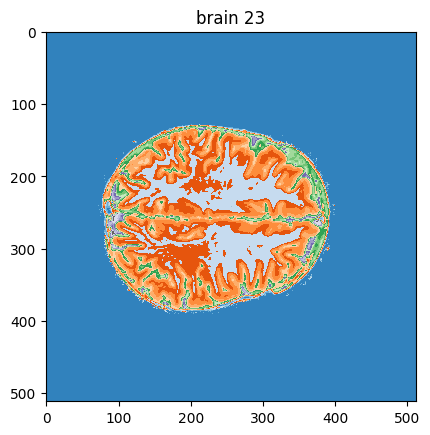

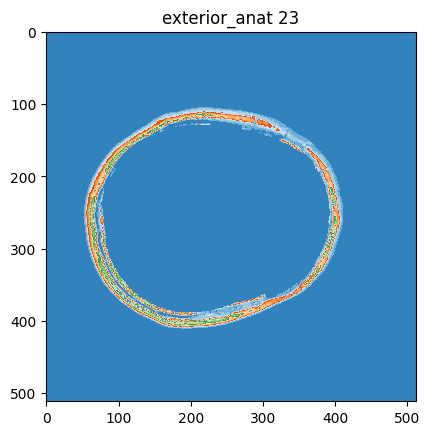

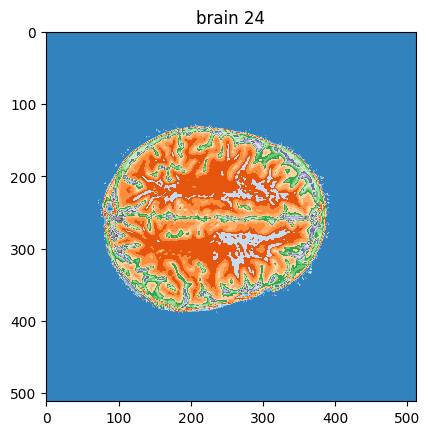

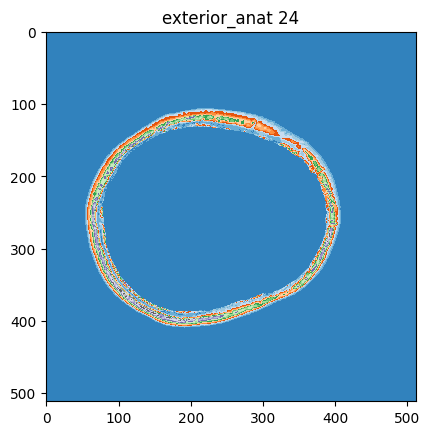

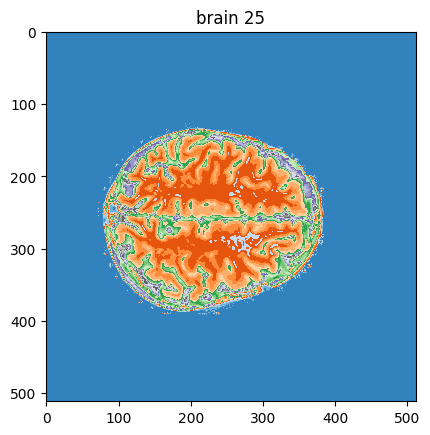

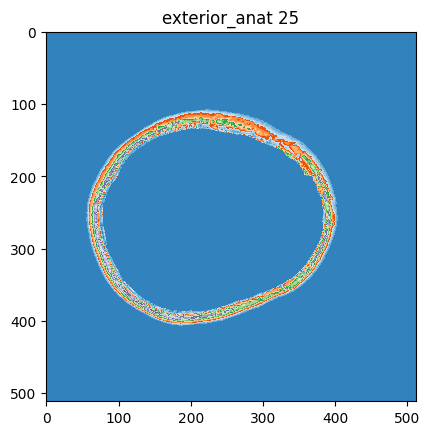

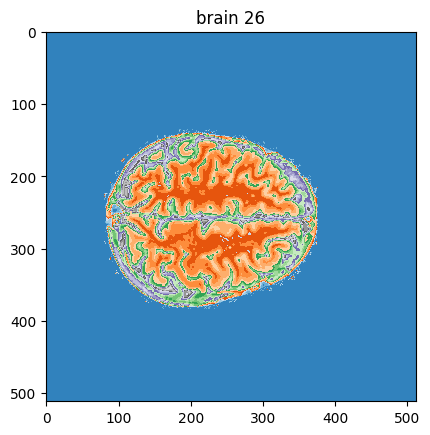

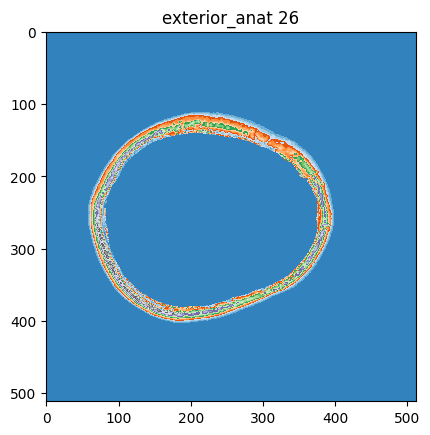

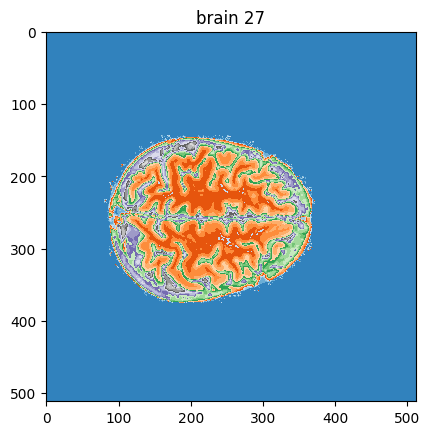

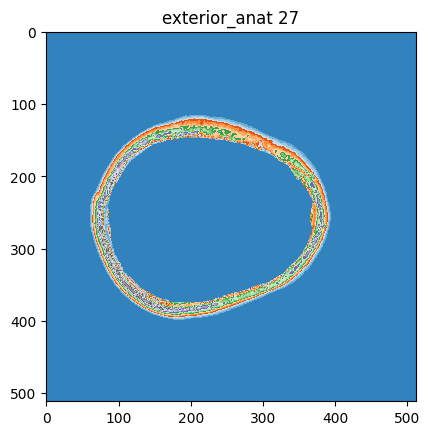

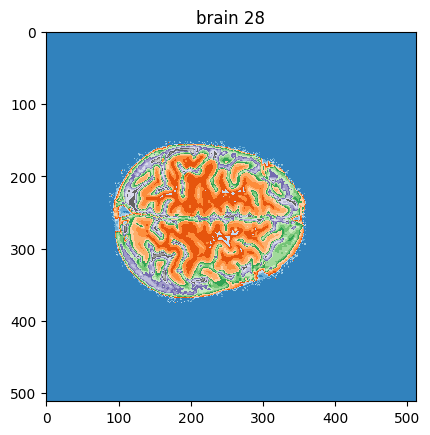

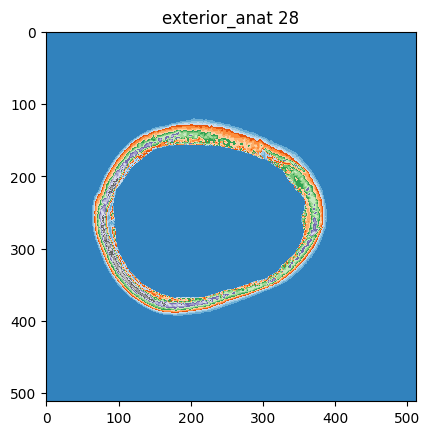

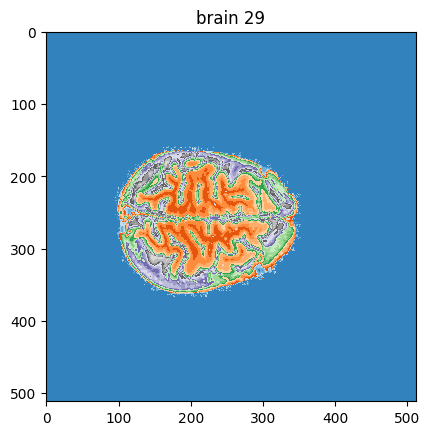

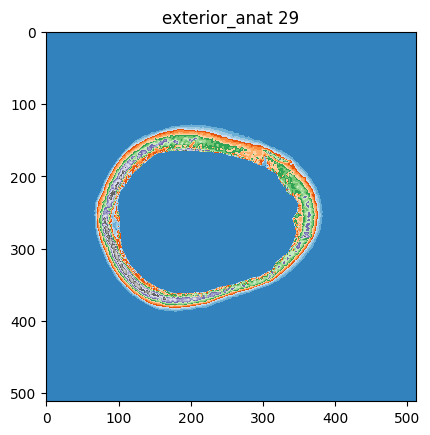

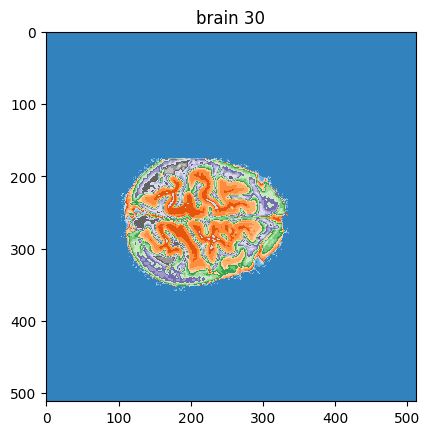

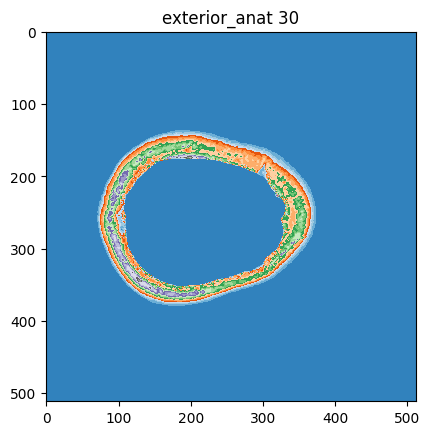

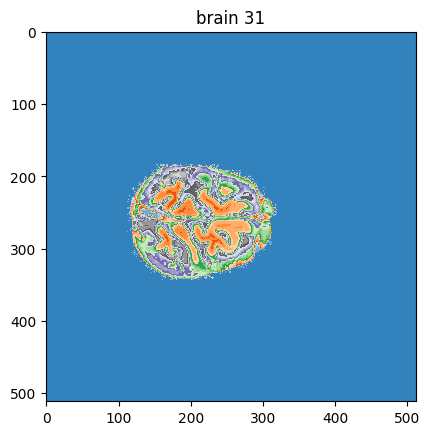

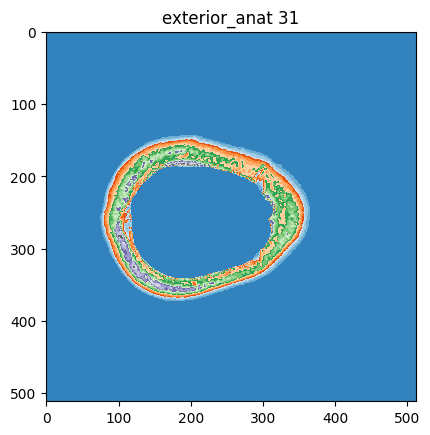

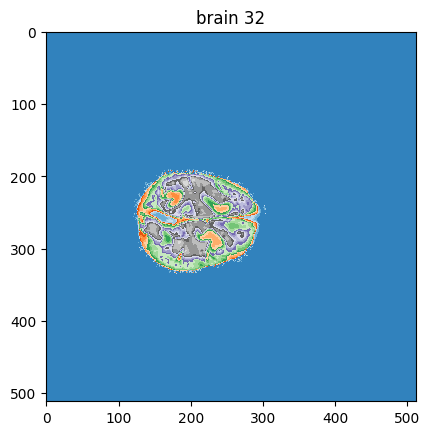

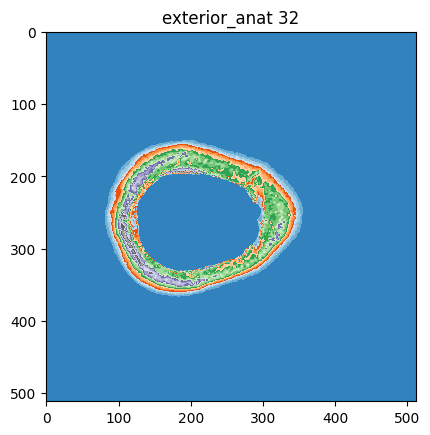

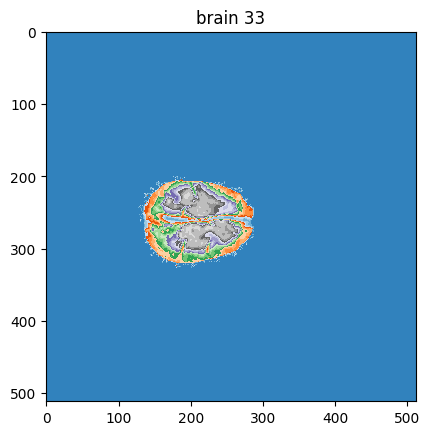

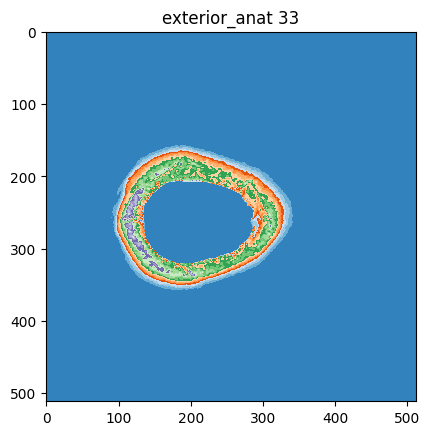

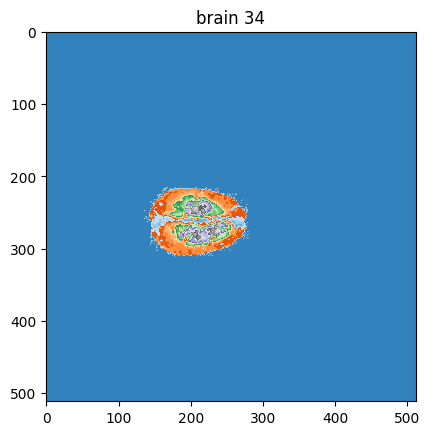

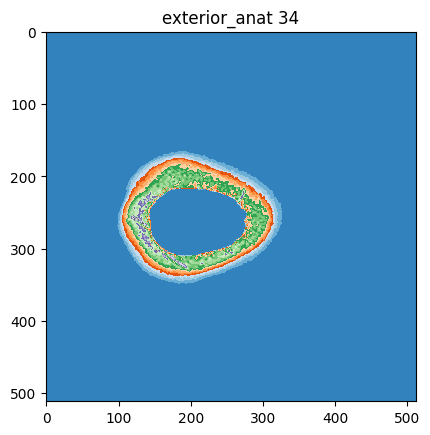

In [69]:
for i in range(brain.shape[2]):
    view_slice(brain[:,:,i], title=f"brain {i}")
    view_slice(exterior_anat[:,:,i], title=f"exterior_anat {i}")

Great! Now we can save it and move it into blender

In [70]:
np.save("{}/brain_grid.npy".format(output_folder), brain)
np.save("{}/exterior_anat_grid.npy".format(output_folder), exterior_anat)